In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
# sys.path.append("/home/jovyan/pschizhov/ODE_for_Neural_Optimal_Transport")
sys.path.append("..")


ADJOINT = False
SOLVER_METHOD = 'euler'
SOLVER_TS = 10
TOL = 1e-4

DEVICE_IDS = [0]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 16

BATCH_SIZE = 64

PLOT_INTERVAL = 50
# COST = 'mse' # Mean Squared Error
COST = 'dynamic_ot'
CPKT_INTERVAL = 2000
MAX_STEPS = 100001
SEED = 0x000000

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torchdyn.core import NeuralODE
import functorch
import einops
import wandb

assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)
torch.cuda.is_available()

import os, sys
import time
from tqdm import tqdm
import gc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from models.models import Unet
from models.ode import ODEBlock2
from src_not.resnet2 import ResNet_D
from src_not.tools import unfreeze, freeze
from models.simple_mlp import SimpleSequential, SimpleSequentialTimed

In [4]:
ode_f = UNet_func(3, 3, base_factor=48).cuda()
T = ODEBlock2(ode_f,
              t_eval=torch.linspace(0,1,SOLVER_TS).float(),
             sensitivity='adjoint' if ADJOINT else'autograd',
              method=SOLVER_METHOD).cuda()

f = ResNet_D(IMG_SIZE, nc=3, nfilter=64, nfilter_max=256).cuda()

0. 8 Гауссиан в moon dataset
1. 5 шагов эйлера, без adjointa -> потому что не честно решаем ОДУ -> чтобы показать, разрешение 32, fid раз в 1000 шагов (должен быть убывающим). Это скорее всего будет работать за адекватное время, но проблема с возвращением назад, для этого добавляем регуляризатор со случайной точкой на траекториии в [0, 1] -> есть шанс, возможно можно будет обратить.



In [5]:
BATCH_SIZE = 64

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
usps_train = datasets.USPS(root='./data', train=True, download=True, transform=TRANSFORM)

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
usps_loader = torch.utils.data.DataLoader(usps_train, batch_size=BATCH_SIZE, shuffle=True)

# Load test datasets
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
usps_test = datasets.USPS(root='./data', train=False, download=True, transform=TRANSFORM)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)
usps_test_loader = torch.utils.data.DataLoader(usps_test, batch_size=BATCH_SIZE)

# We only a few samples from them for the qualitative analysis
X_test_fixed = next(iter(mnist_test_loader))[0]
Y_test_fixed = next(iter(usps_test_loader))[0]

del mnist_test_loader, usps_test_loader, mnist_test, usps_test

Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets


(<Figure size 1000x100 with 10 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

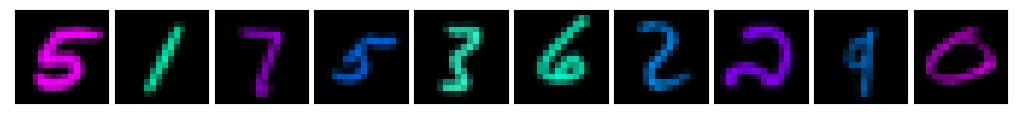

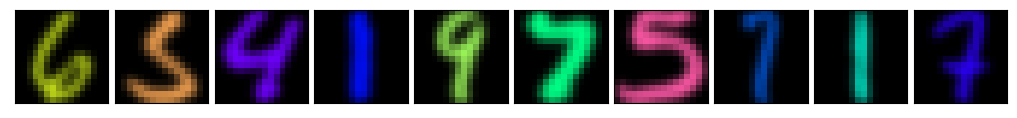

In [6]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)
    return fig, axes

def plot_images3(batch):
    fig, axes = plt.subplots(3, 10, figsize=(10, 3), dpi=100)
    for j in range(3):
        for i in range(10):
            axes[j][i].imshow(batch[j, i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
            axes[j][i].set_xticks([]); axes[j][i].set_yticks([])
        fig.tight_layout(pad=0.1)
    return fig, axes

print('Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets')
plot_images(next(iter(mnist_loader))[0])
plot_images(next(iter(usps_loader))[0])

(<Figure size 1000x300 with 30 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

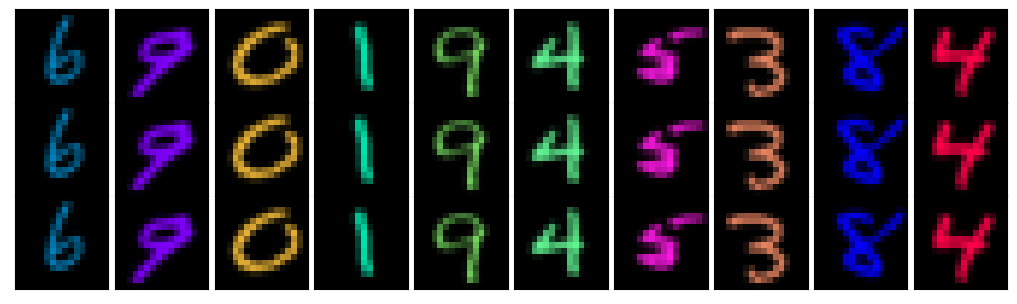

In [7]:
plot_images3(einops.repeat(next(iter(mnist_loader))[0], 'b c h w -> j b c h w', j=3))

In [8]:
iter_mnist, iter_usps = iter(mnist_loader), iter(usps_loader)
#TODO batchsize useless
def sample_mnist(batch_size):
    global iter_mnist, mnist_loader
    try:
        return next(iter_mnist)[0]
    except StopIteration:
        iter_mnist = iter(mnist_loader)
        return next(iter_mnist)[0]

def sample_usps(batch_size):
    global iter_usps, usps_loader
    try:
        return next(iter_usps)[0]
    except StopIteration:
        iter_usps = iter(usps_loader)
        return next(iter_usps)[0]
    
    
    
def plot_trajectories(generator, sampler_x, sampler_y, num_steps=25, backward=False):
    global X_test_fixed, Y_test_fixed
    with torch.no_grad():          
        int_time = generator.integration_time
        new_int_time = torch.linspace(0, 1, num_steps)
        if backward:
            new_int_time = torch.linspace(0, 1, num_steps).flip(dims=(0,))
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
            
        generator.integration_time = new_int_time
        T_X_test_fixed, _ = generator(torch.tensor(X_test_fixed, device='cuda'), return_trajectory=False)
        T_X_test_fixed = T_X_test_fixed.detach().cpu()
        arr_vis = torch.stack((X_test_fixed, T_X_test_fixed, Y_test_fixed), dim=0)
        print('Mnist images X, mapped images T(X), unpaired USPS images Y')
        fig, axes = plot_images3(arr_vis)
        
        generator.integration_time = int_time
        if backward:
            X_test_fixed, Y_test_fixed = Y_test_fixed, X_test_fixed
       

    return fig, axes
    

/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/user/conda/lib/python3.7/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


Mnist images X, mapped images T(X), unpaired USPS images Y


(<Figure size 1000x300 with 30 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

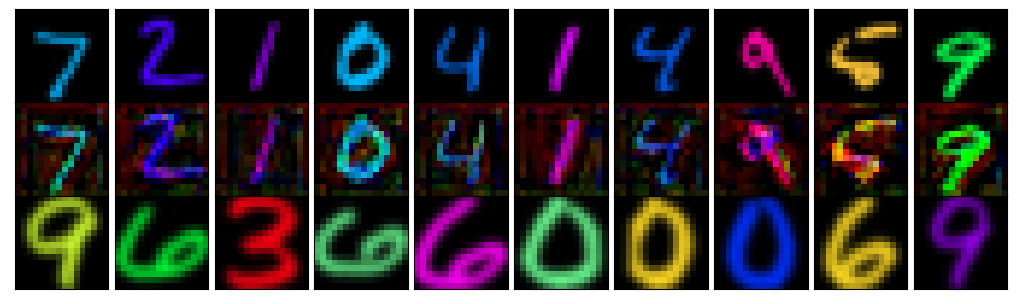

In [9]:
plot_trajectories(T,
                  sample_mnist,
                  sample_usps,
                  num_steps=10,
                  backward=False)

In [10]:
def train_loop(T, f, X_sampler, Y_sampler, BATCH_SIZE, T_ITERS=10, MAX_STEPS=100001, regularized=True):

    wandb.init(project='ode_strong_not', name=f'dynamic_ot_euler10step_MNIST_SPSS') 
    OUTPUT_PATH = f'checkpoints/dynamic_ot_euler10step_MNIST_SPSS'
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    T_LR = 1e-4
    f_LR = 1e-4
    
    T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
    f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)
    
    for step in tqdm(range(MAX_STEPS)):
        # T optimization
        unfreeze(T); freeze(f)
        avg_gen_opt_step_time = 0
        avg_num_func_eval_per_opt_step = 0
        for t_iter in range(T_ITERS):

            generator_opt_step_time = time.time()
            T_opt.zero_grad()
            X = X_sampler(BATCH_SIZE).cuda()

            t_eval, trajectories, reg_loss = T(X, return_trajectory=True)
            T_X = trajectories[-1]

            # total_loss
            if COST == 'mse':
                T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean() + reg_loss      
            elif COST == 'dynamic_ot':
                T_loss = reg_loss - f(T_X).mean() 
            else:
                raise Exception('Unknown COST')

            with torch.no_grad():
                num_func_eval = T.nfe
            T_loss.backward(); T_opt.step()
            with torch.no_grad():
                num_func_eval_per_opt_step = T.nfe - num_func_eval

            generator_opt_step_time = time.time() - generator_opt_step_time
            avg_gen_opt_step_time += generator_opt_step_time
            avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step

        avg_gen_opt_step_time /= T_ITERS 
        avg_num_func_eval_per_opt_step /= T_ITERS
        # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()
        
        # f optimization
        freeze(T); unfreeze(f)
        discriminator_opt_step_time = time.time()
        X = X_sampler(BATCH_SIZE).cuda()
        with torch.no_grad():
            T_X, _ = T(X)
        Y = Y_sampler(BATCH_SIZE).cuda()
        f_opt.zero_grad()
        f_loss = f(T_X).mean() - f(Y).mean()
        f_loss.backward(); f_opt.step();
        discriminator_opt_step_time = time.time() - discriminator_opt_step_time
        wandb.log({'f_loss' : f_loss.item(),
                   'T_loss' : T_loss.item(),
                   'reg_loss' : reg_loss.item(),
                  'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
                  'avg_gen_opt_step_time' : avg_gen_opt_step_time,
                  'discriminator_opt_step_time' : discriminator_opt_step_time
                  }, step=step) 

        if step % PLOT_INTERVAL == 0:
            print('Plotting')
            # clear_output(wait=True)
            fig, axes = plot_trajectories(T,
                  sample_mnist,
                  sample_usps,
                  num_steps=10,
                  backward=False)
            wandb.log({'Fixed Images' : [wandb.Image(fig)]}, step=step) 
            plt.show(fig); plt.close(fig) 

        if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
#             freeze(T); 

#             print('Computing FID')
#             mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
#             fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
#             wandb.log({f'FID (Test)' : fid}, step=step)
            # del mu, sigma

            torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
    #         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
    #         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
    #         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt')

/home/user/conda/lib/python3.7/site-packages/notebook/utils.py:282: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: peter_chizhov. Use `wandb login --relogin` to force relogin


  0%|          | 0/100001 [00:00<?, ?it/s]/home/user/conda/lib/python3.7/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


/home/user/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


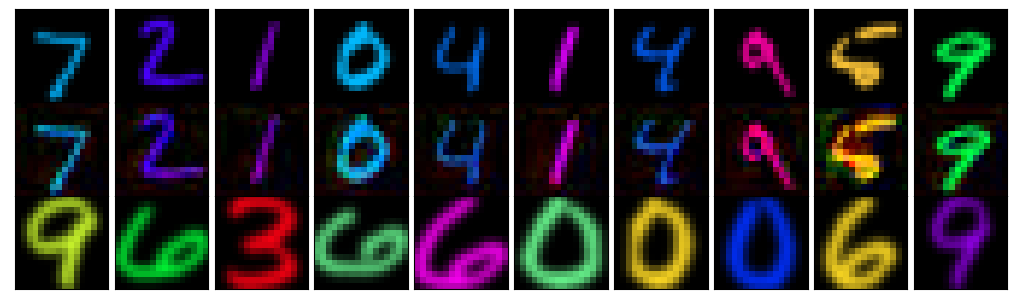

  0%|          | 50/100001 [01:55<62:31:43,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


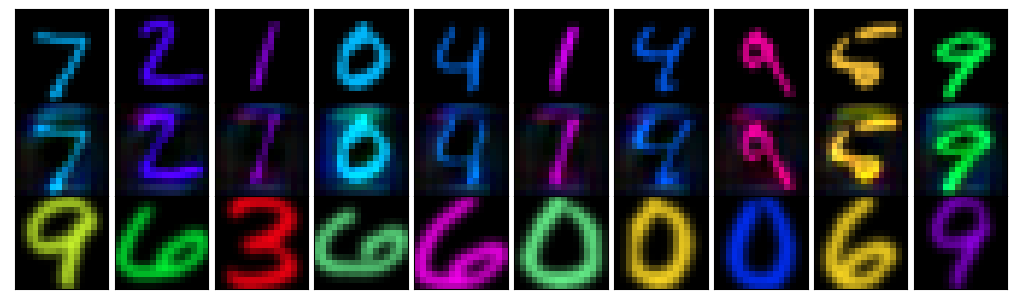

  0%|          | 100/100001 [03:50<62:56:04,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


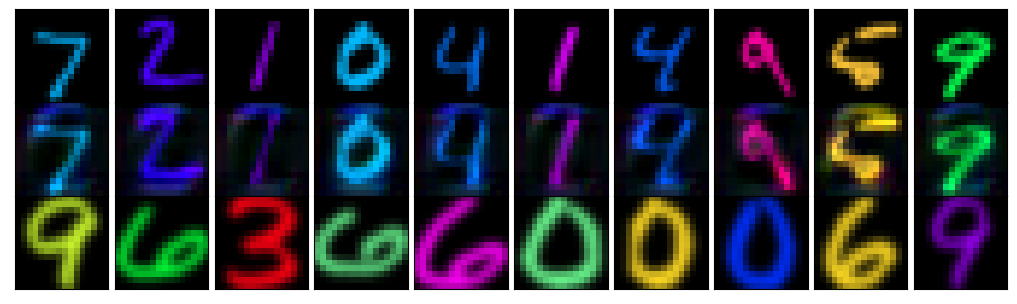

  0%|          | 150/100001 [05:45<62:29:26,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


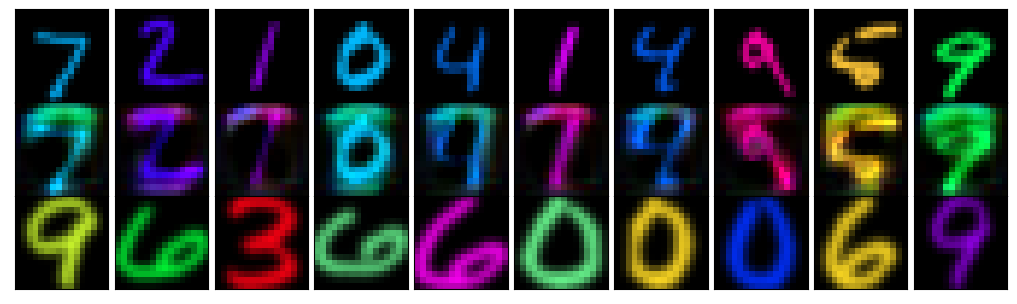

  0%|          | 200/100001 [07:41<64:21:49,  2.32s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


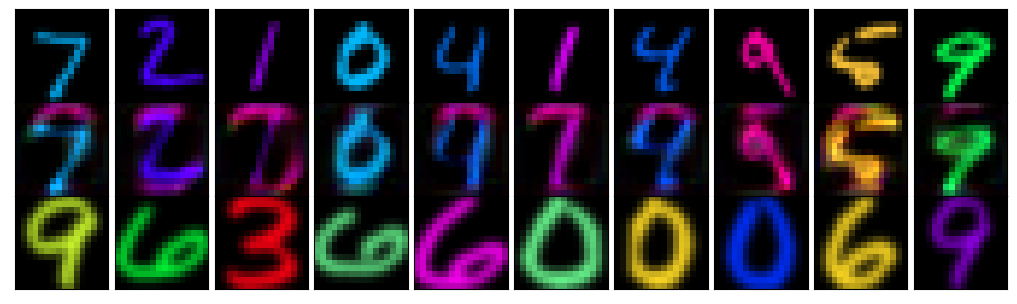

  0%|          | 250/100001 [09:36<62:48:45,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


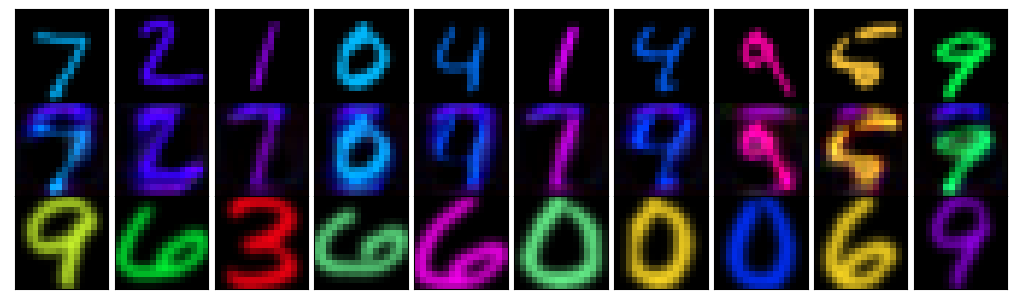

  0%|          | 300/100001 [11:31<63:31:43,  2.29s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


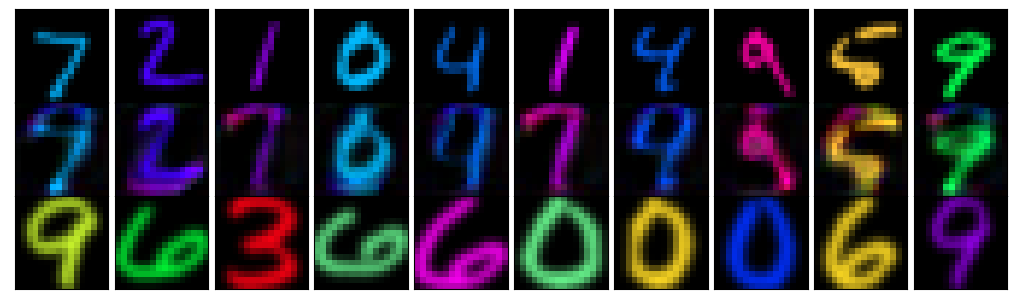

  0%|          | 350/100001 [13:27<62:41:57,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


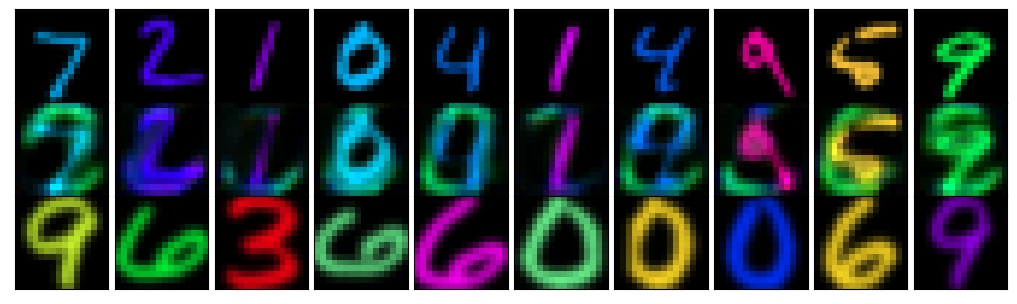

  0%|          | 400/100001 [15:22<62:51:46,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


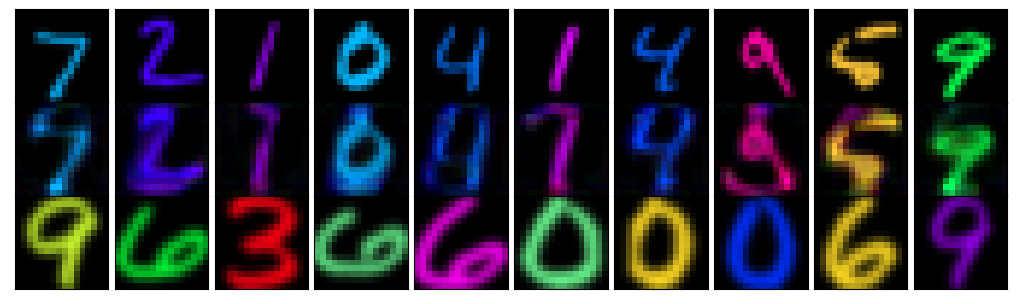

  0%|          | 450/100001 [17:20<64:06:24,  2.32s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


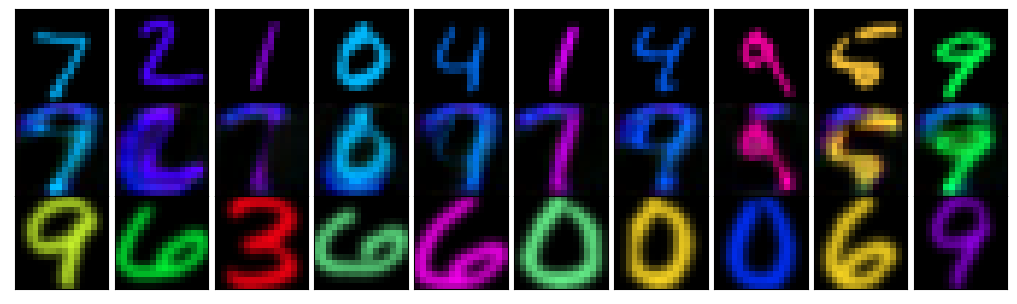

  0%|          | 500/100001 [19:17<63:59:03,  2.31s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


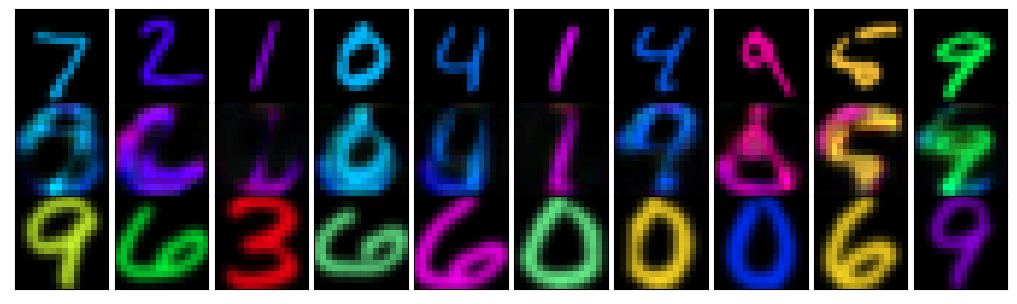

  1%|          | 550/100001 [21:13<63:30:32,  2.30s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


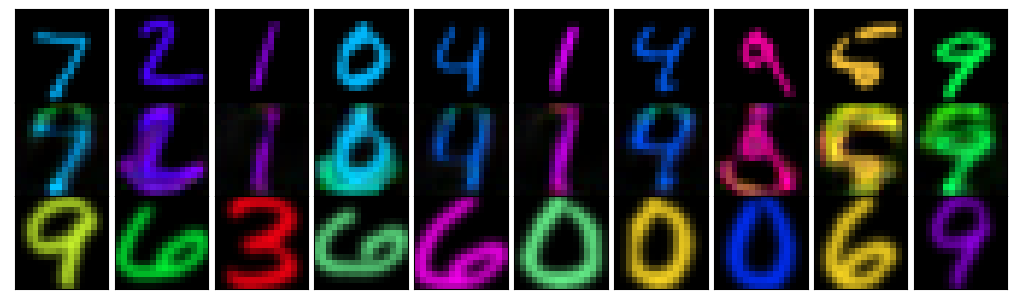

  1%|          | 600/100001 [23:10<64:02:46,  2.32s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


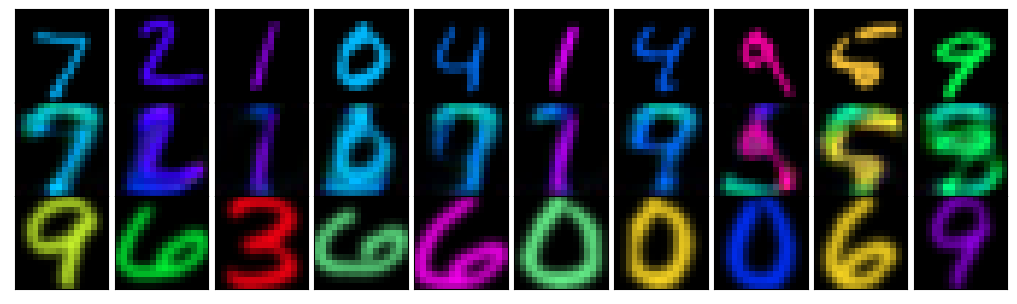

  1%|          | 650/100001 [25:06<63:28:10,  2.30s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


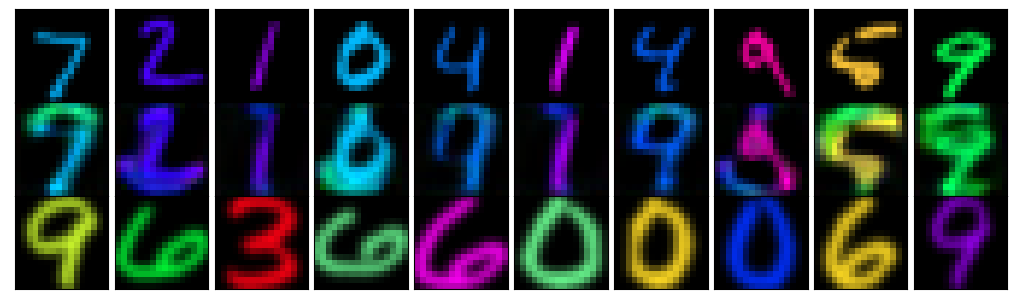

  1%|          | 700/100001 [27:04<63:57:58,  2.32s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


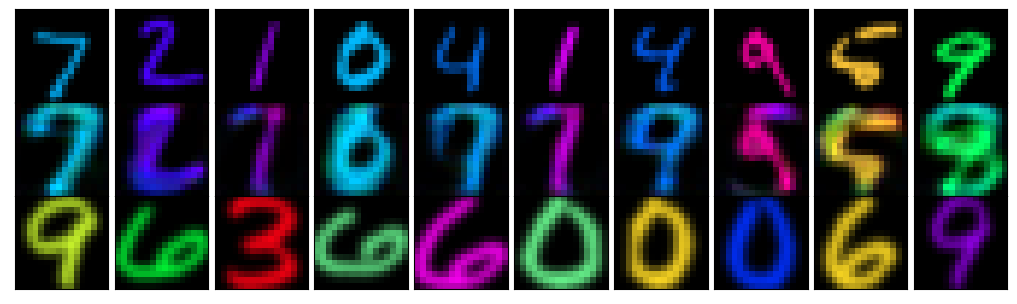

  1%|          | 750/100001 [29:01<62:44:06,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


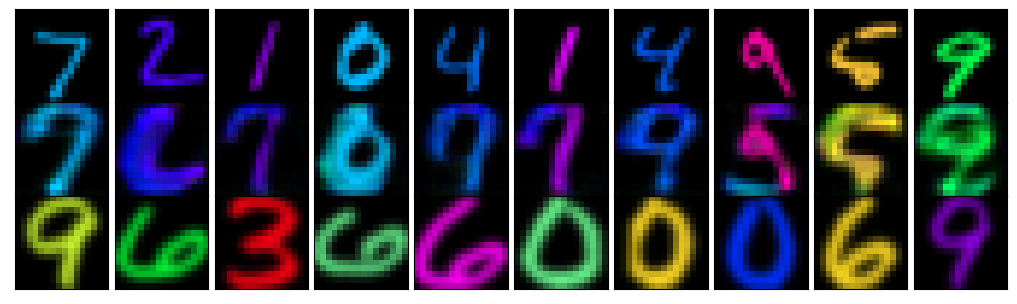

  1%|          | 800/100001 [30:57<63:41:42,  2.31s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


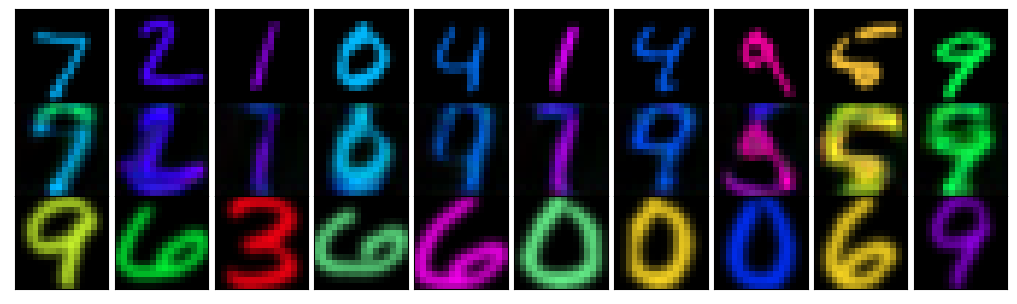

  1%|          | 850/100001 [32:55<66:36:12,  2.42s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


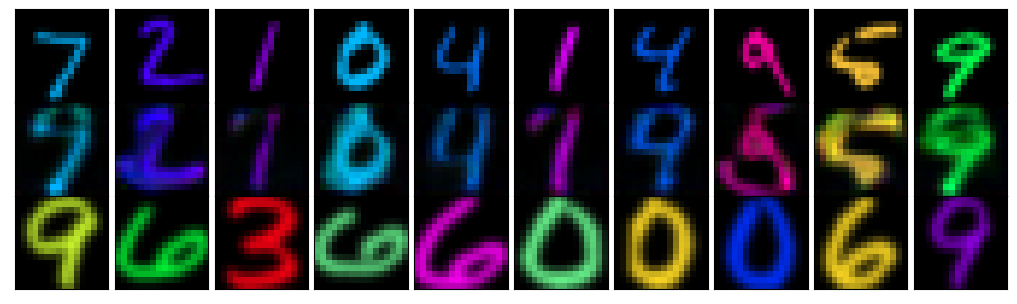

  1%|          | 900/100001 [34:51<62:59:37,  2.29s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


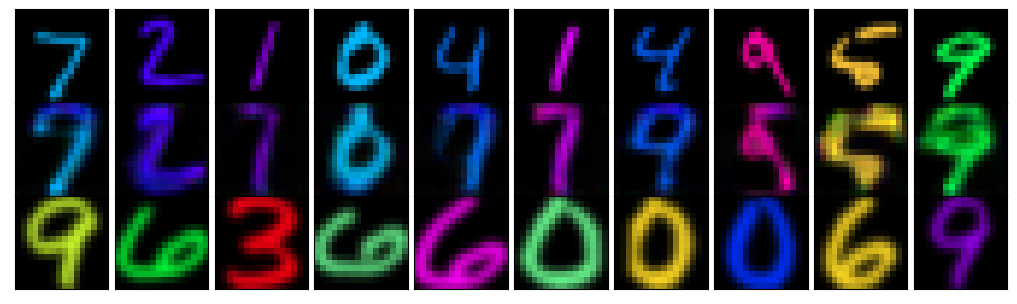

  1%|          | 950/100001 [36:48<63:18:54,  2.30s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


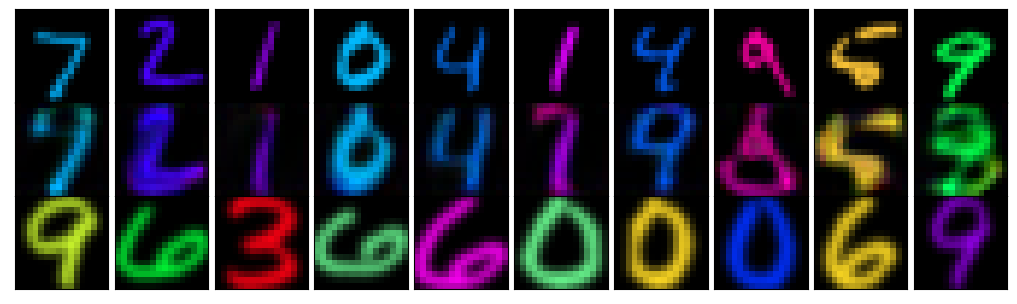

  1%|          | 1000/100001 [38:45<63:18:37,  2.30s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


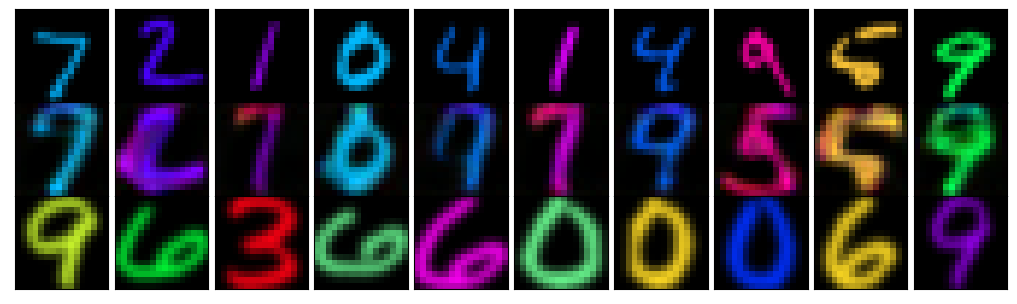

  1%|          | 1050/100001 [40:42<63:17:53,  2.30s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


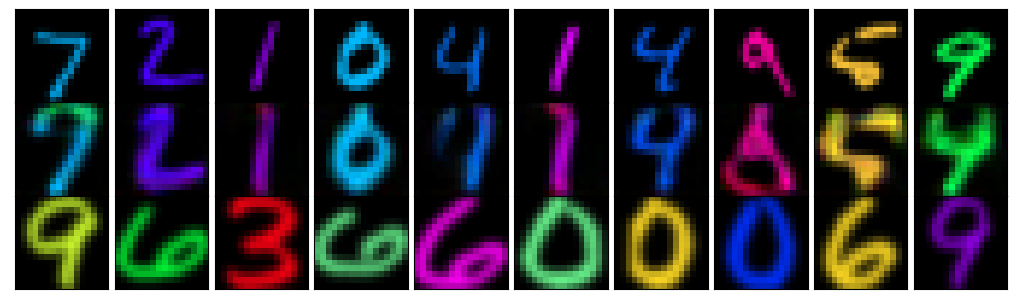

  1%|          | 1100/100001 [42:39<62:37:39,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


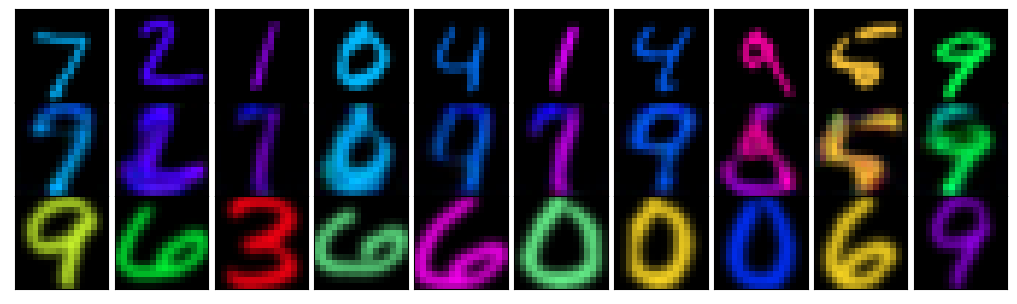

  1%|          | 1150/100001 [44:36<63:48:50,  2.32s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


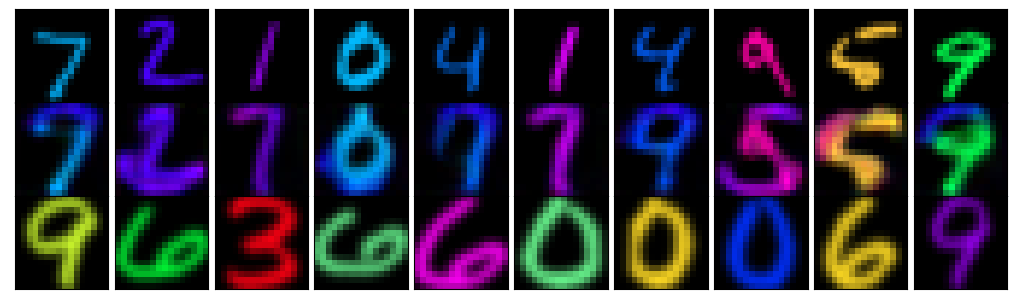

  1%|          | 1200/100001 [46:33<63:17:56,  2.31s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


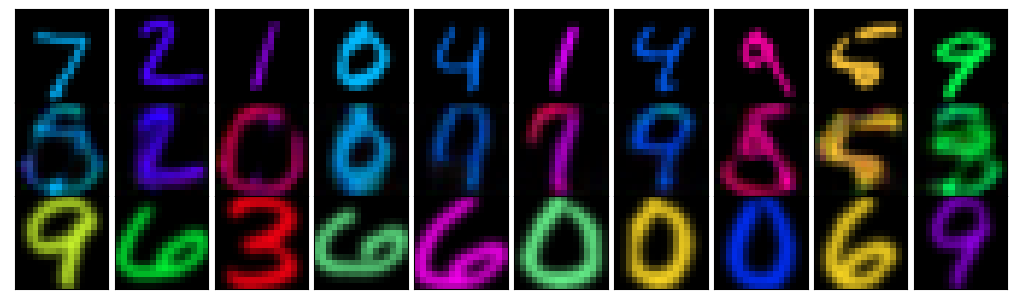

  1%|          | 1250/100001 [48:29<62:49:12,  2.29s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


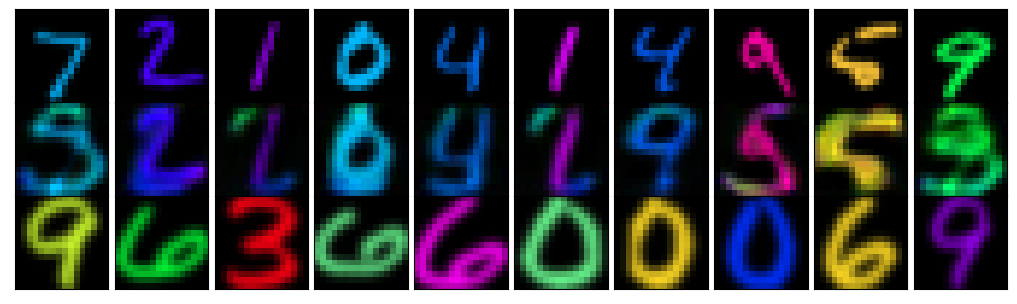

  1%|▏         | 1300/100001 [50:24<62:22:51,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


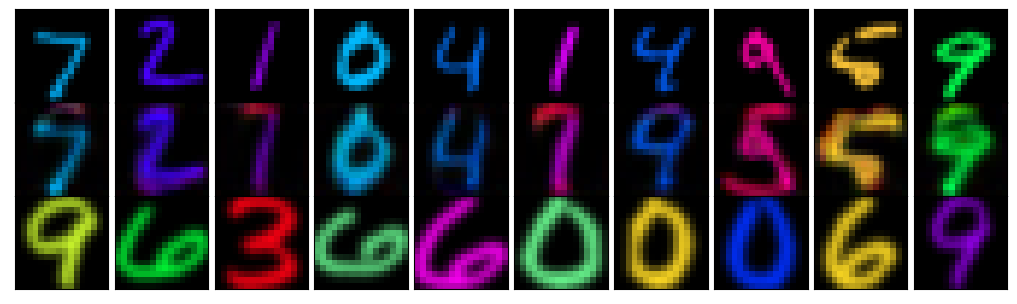

  1%|▏         | 1350/100001 [52:20<62:40:22,  2.29s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


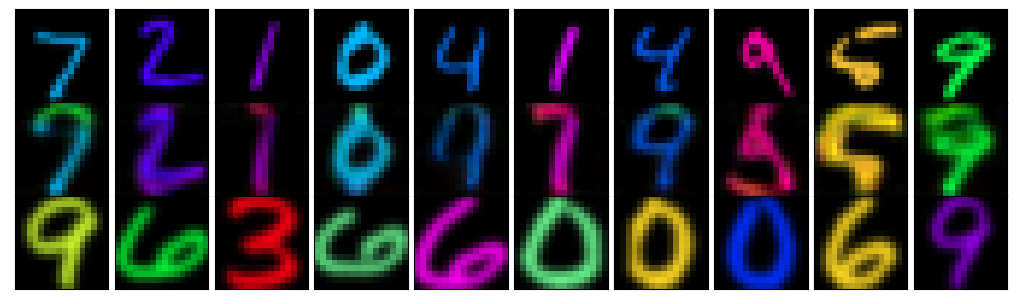

  1%|▏         | 1400/100001 [54:15<61:44:26,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


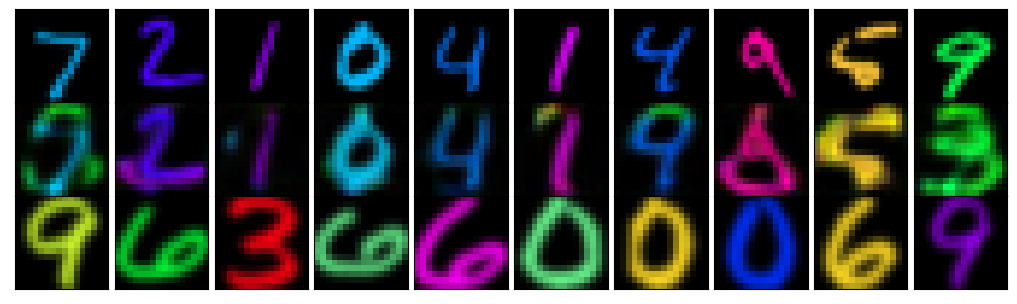

  1%|▏         | 1450/100001 [56:11<62:52:12,  2.30s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


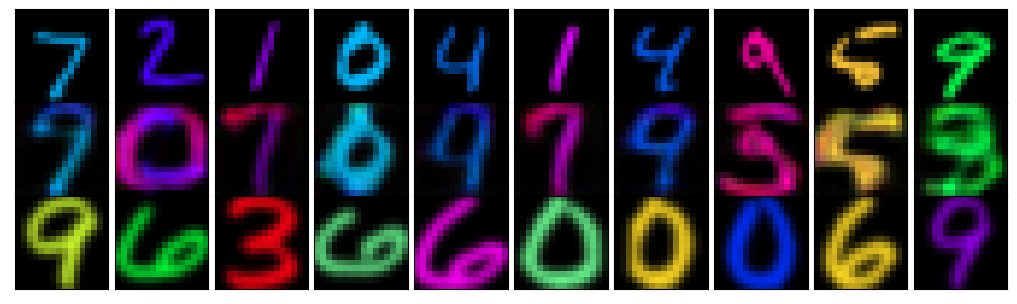

  1%|▏         | 1500/100001 [58:08<63:09:02,  2.31s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


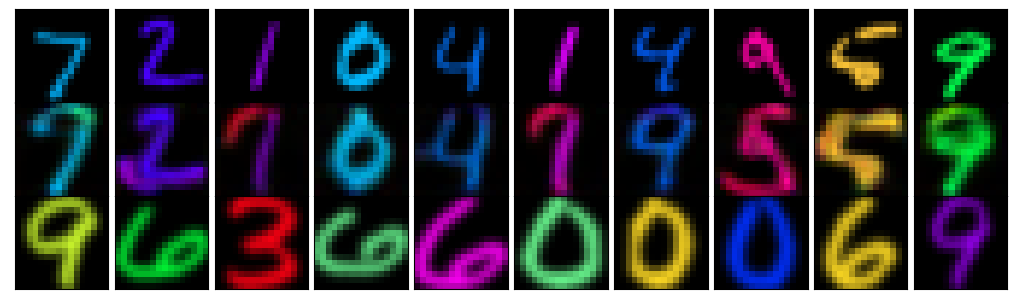

  2%|▏         | 1550/100001 [1:00:04<62:52:43,  2.30s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


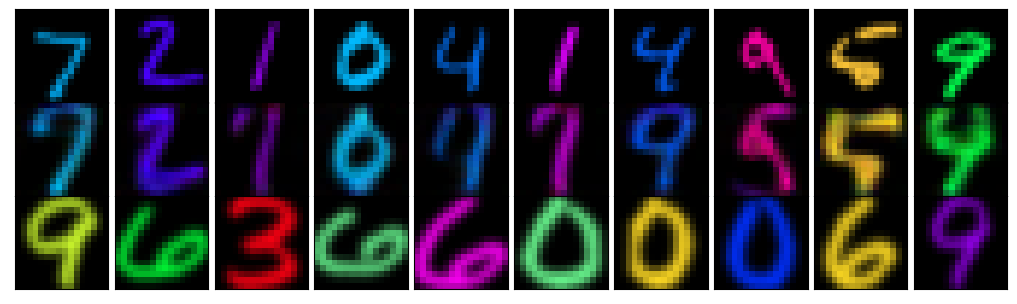

  2%|▏         | 1600/100001 [1:02:02<63:18:16,  2.32s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


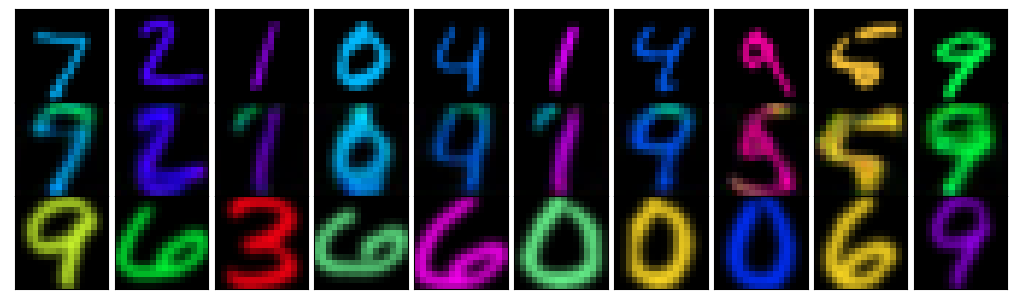

  2%|▏         | 1650/100001 [1:03:59<63:38:13,  2.33s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


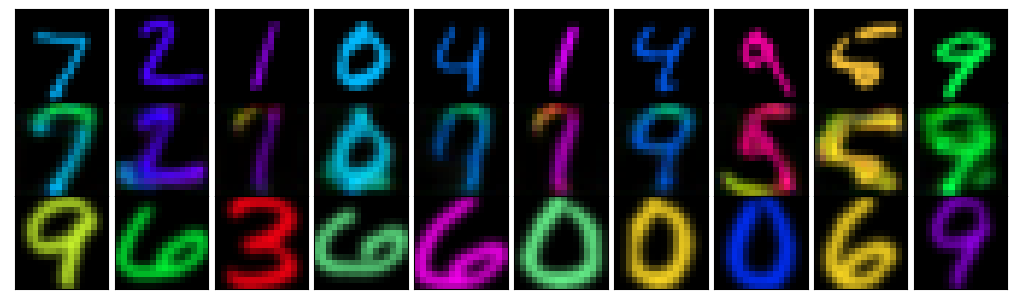

  2%|▏         | 1700/100001 [1:05:56<63:57:41,  2.34s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


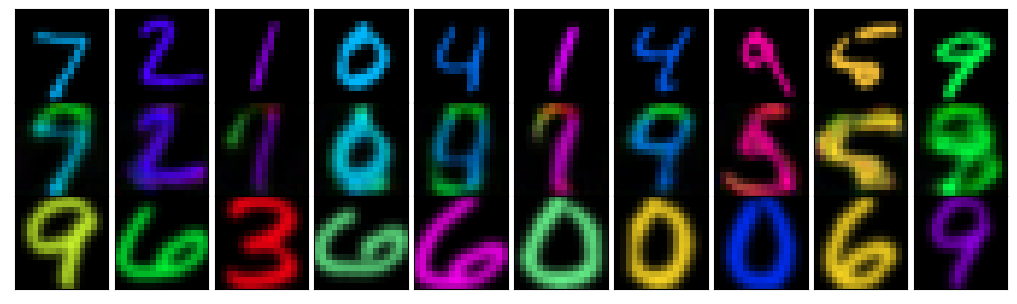

  2%|▏         | 1750/100001 [1:07:53<61:48:01,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


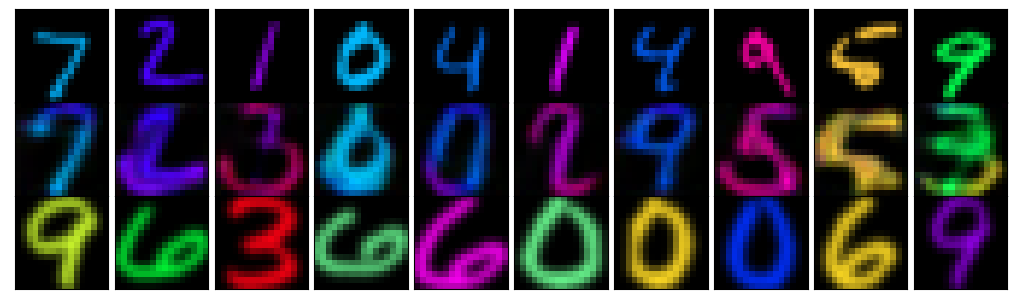

  2%|▏         | 1800/100001 [1:09:50<64:39:03,  2.37s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


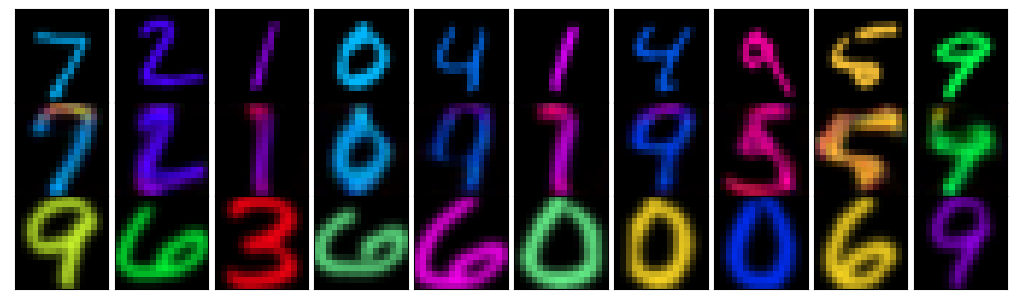

  2%|▏         | 1850/100001 [1:11:47<63:39:06,  2.33s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


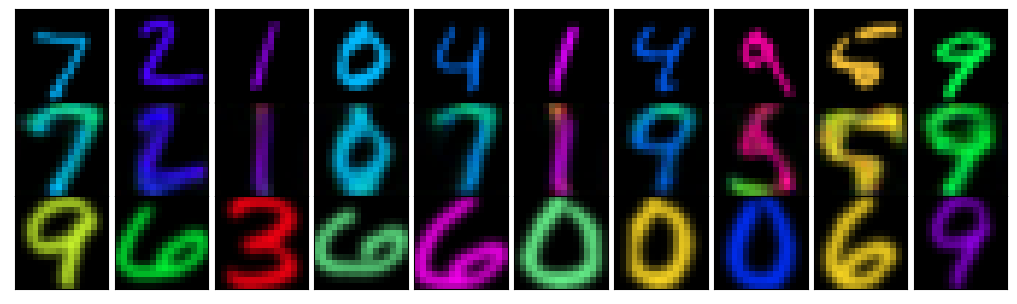

  2%|▏         | 1900/100001 [1:13:43<62:57:18,  2.31s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


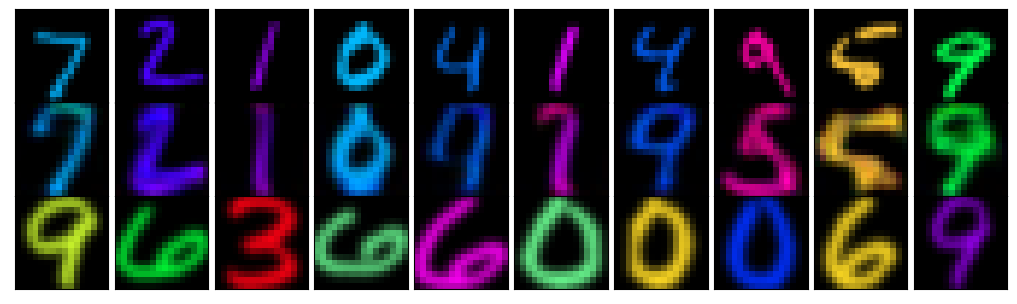

  2%|▏         | 1950/100001 [1:15:41<64:03:16,  2.35s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


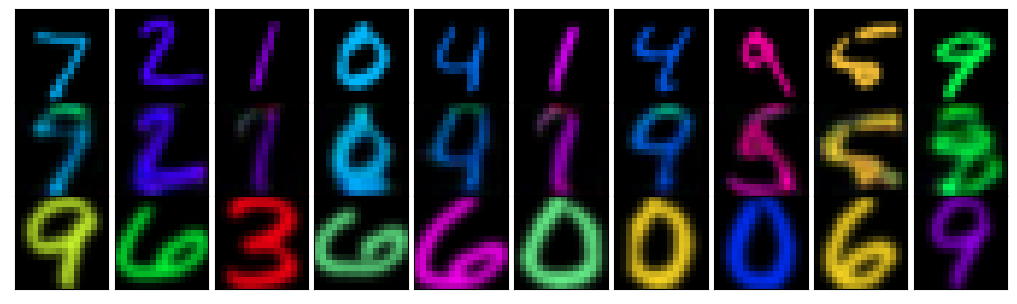

  2%|▏         | 2000/100001 [1:17:39<67:45:07,  2.49s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


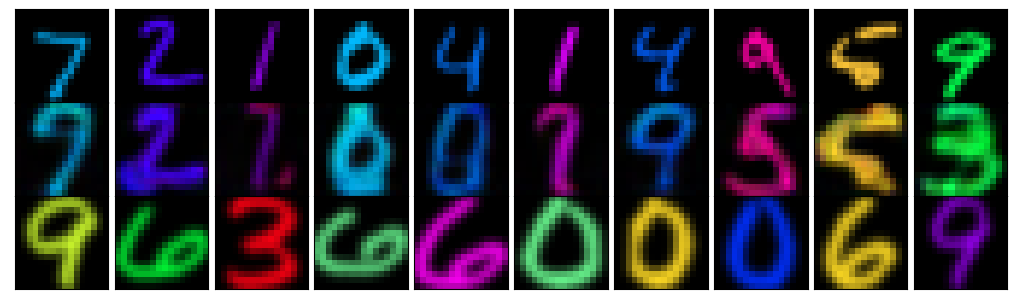

  2%|▏         | 2050/100001 [1:19:38<63:37:08,  2.34s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


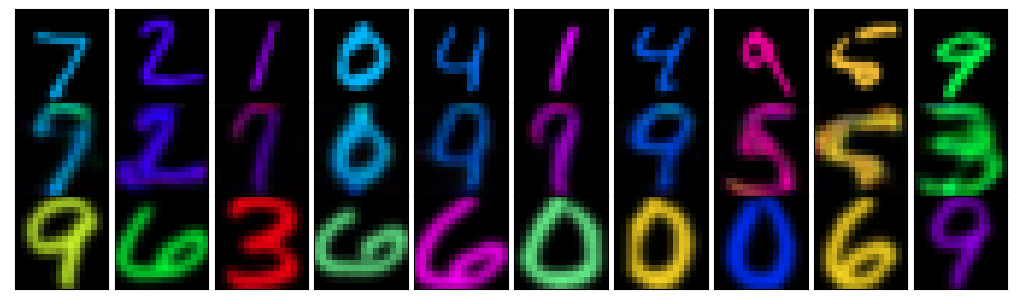

  2%|▏         | 2100/100001 [1:21:36<64:30:50,  2.37s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


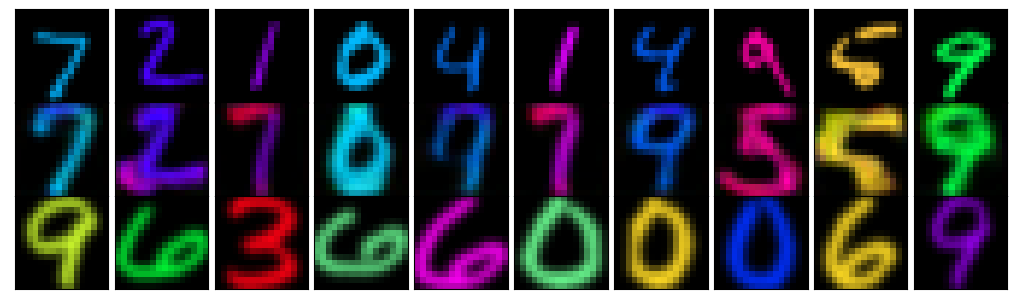

  2%|▏         | 2150/100001 [1:23:32<61:10:15,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


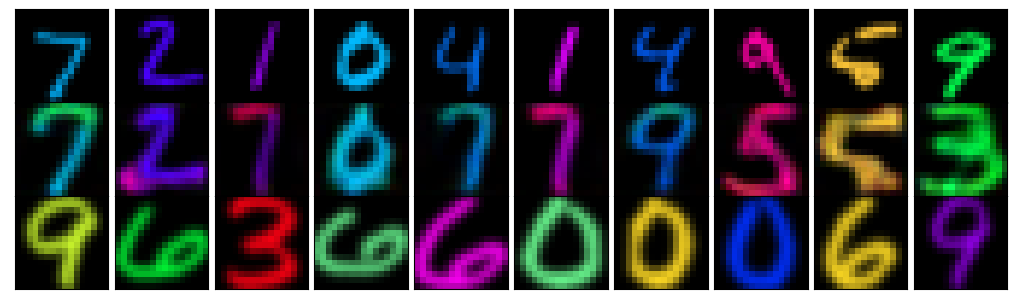

  2%|▏         | 2200/100001 [1:25:27<62:04:03,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


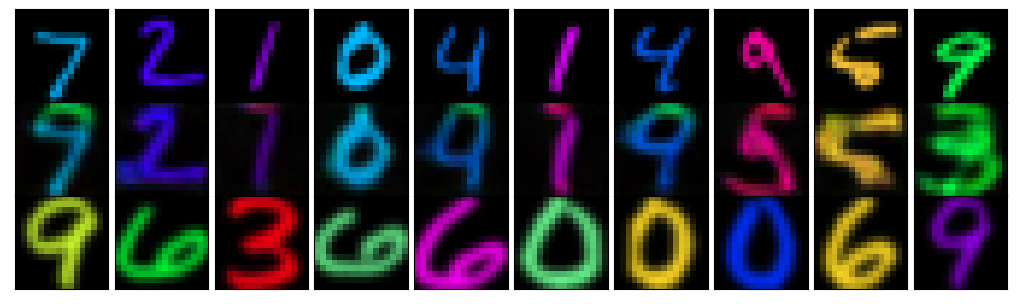

  2%|▏         | 2250/100001 [1:27:22<61:15:21,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


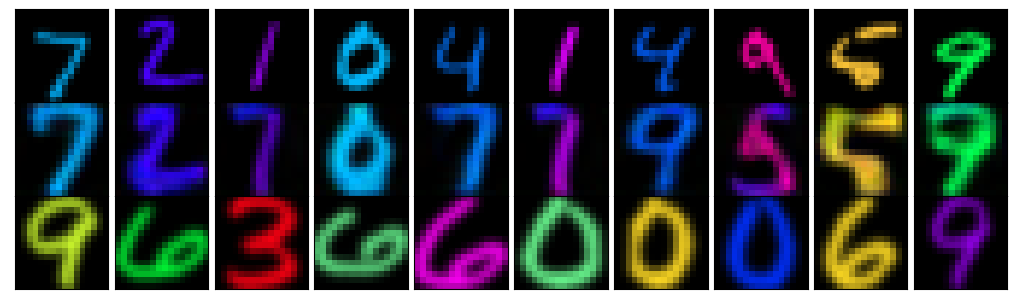

  2%|▏         | 2300/100001 [1:29:18<61:53:31,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


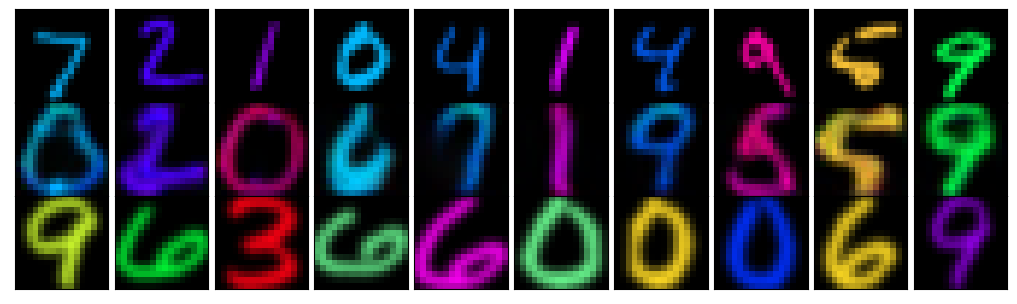

  2%|▏         | 2350/100001 [1:31:13<62:35:36,  2.31s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


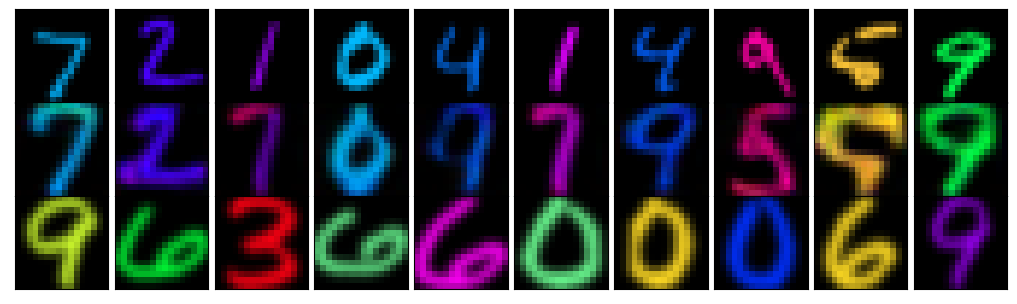

  2%|▏         | 2400/100001 [1:33:08<61:42:53,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


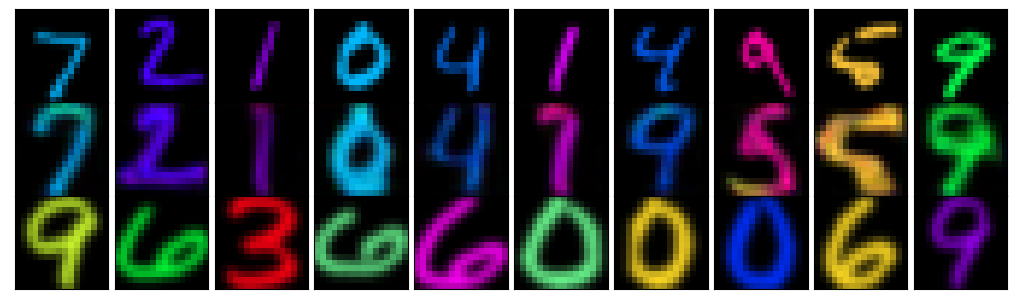

  2%|▏         | 2450/100001 [1:35:04<63:42:12,  2.35s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


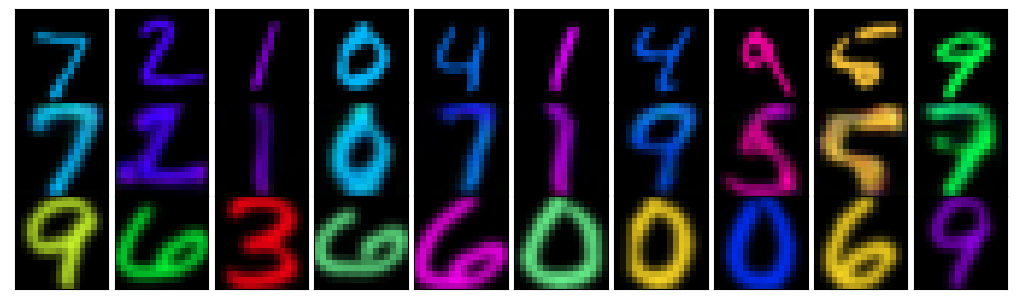

  2%|▏         | 2500/100001 [1:36:58<59:45:04,  2.21s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


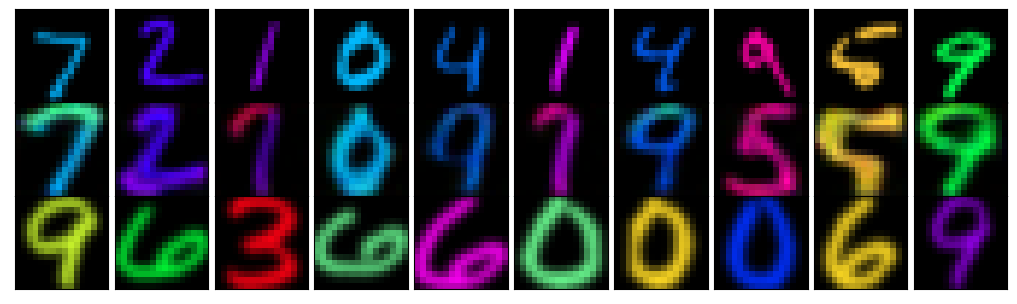

  3%|▎         | 2550/100001 [1:38:51<60:17:31,  2.23s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


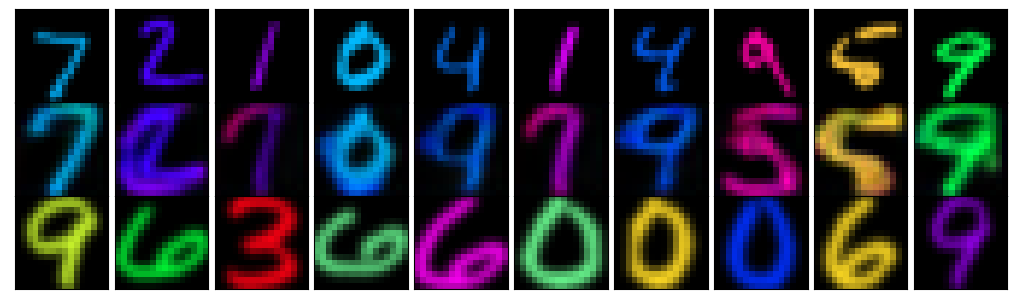

  3%|▎         | 2600/100001 [1:40:44<59:49:38,  2.21s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


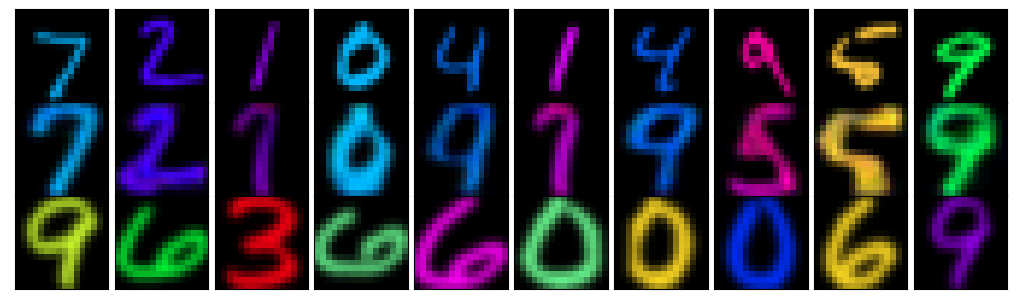

  3%|▎         | 2650/100001 [1:42:37<61:46:51,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


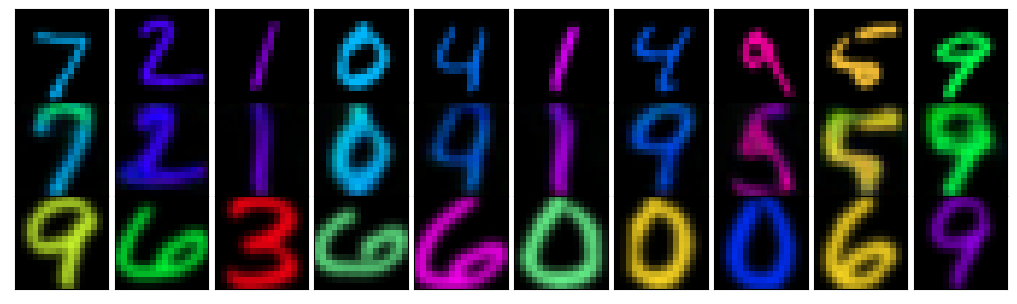

  3%|▎         | 2700/100001 [1:44:32<61:04:59,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


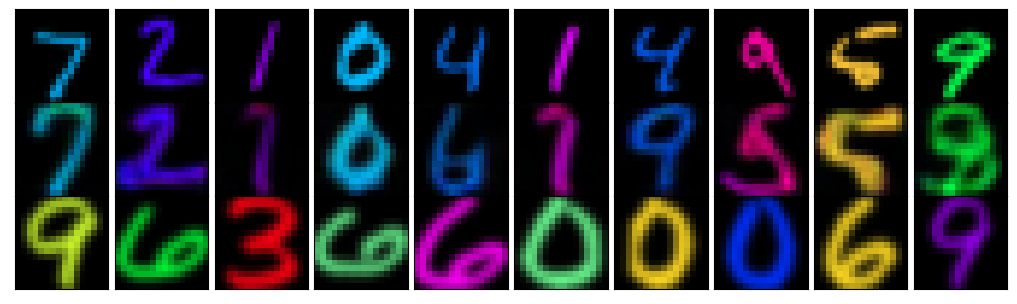

  3%|▎         | 2750/100001 [1:46:27<60:57:10,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


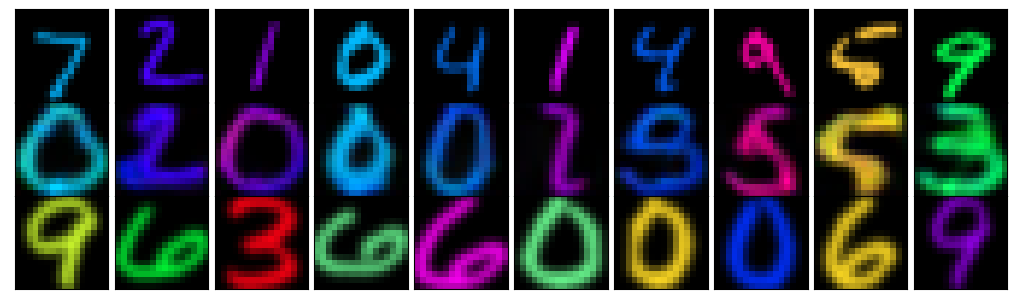

  3%|▎         | 2800/100001 [1:48:22<61:23:32,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


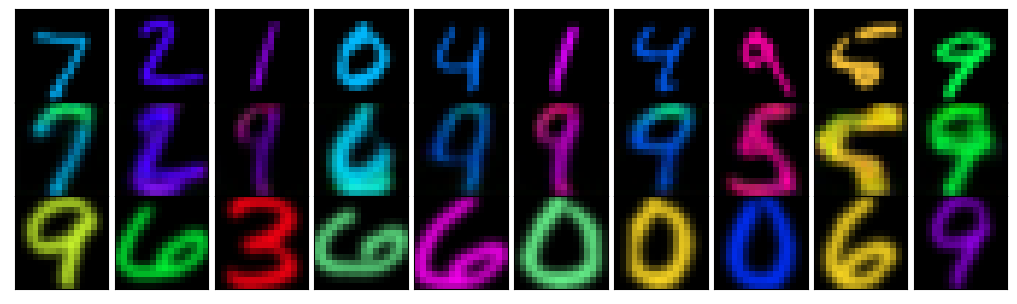

  3%|▎         | 2850/100001 [1:50:16<60:53:27,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


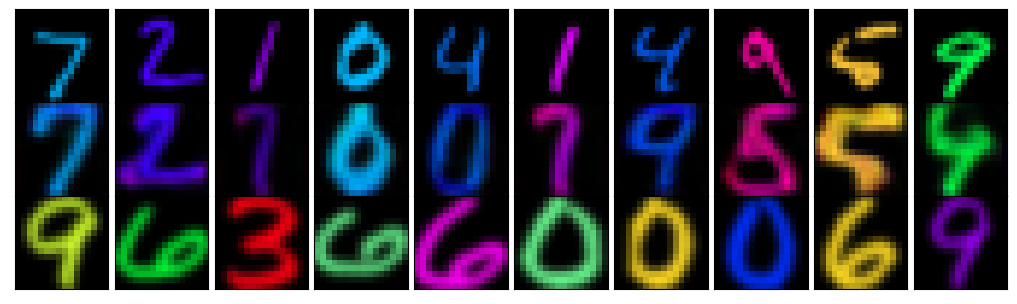

  3%|▎         | 2900/100001 [1:52:11<61:26:00,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


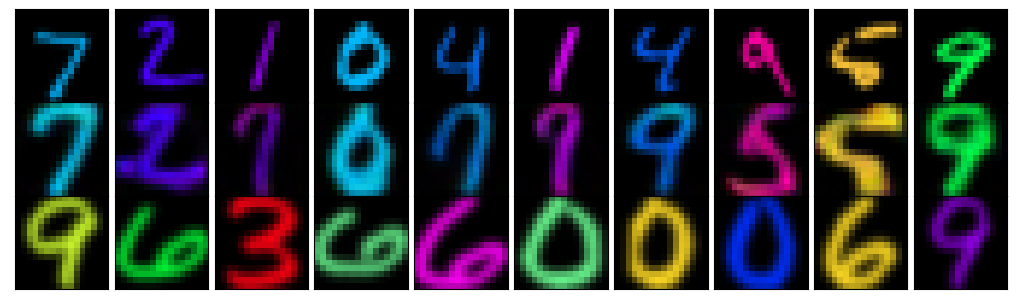

  3%|▎         | 2950/100001 [1:54:06<60:57:51,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


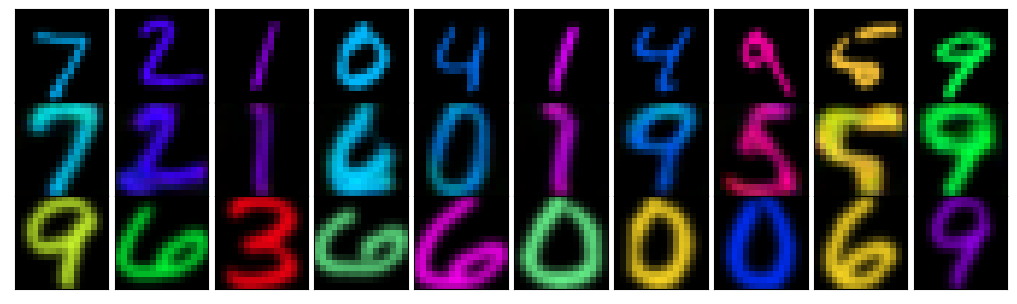

  3%|▎         | 3000/100001 [1:56:01<60:57:56,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


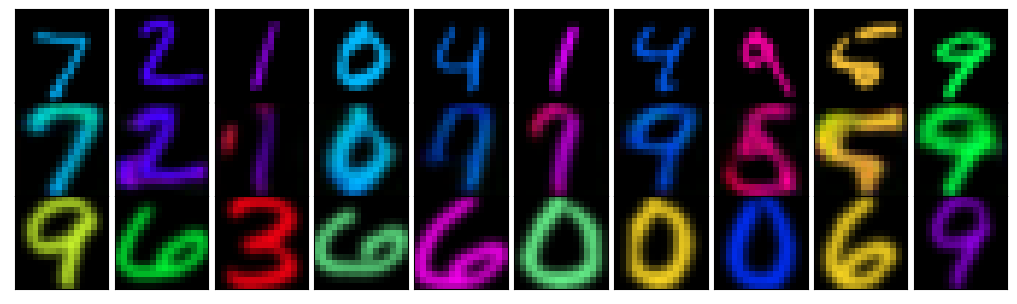

  3%|▎         | 3050/100001 [1:57:56<61:08:22,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


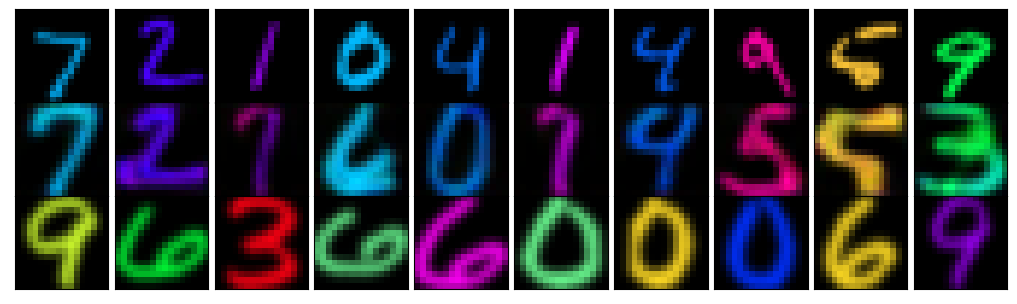

  3%|▎         | 3100/100001 [1:59:50<60:27:32,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


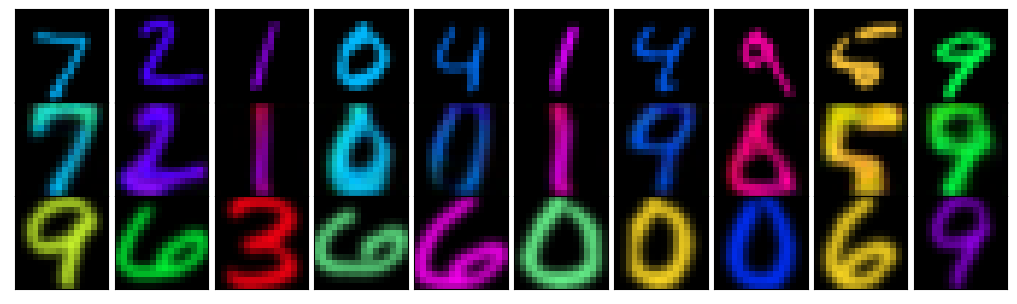

  3%|▎         | 3150/100001 [2:01:44<60:46:54,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


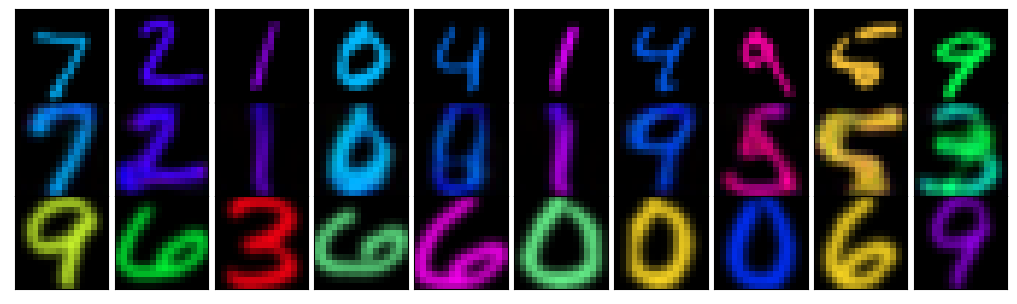

  3%|▎         | 3200/100001 [2:03:39<60:58:16,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


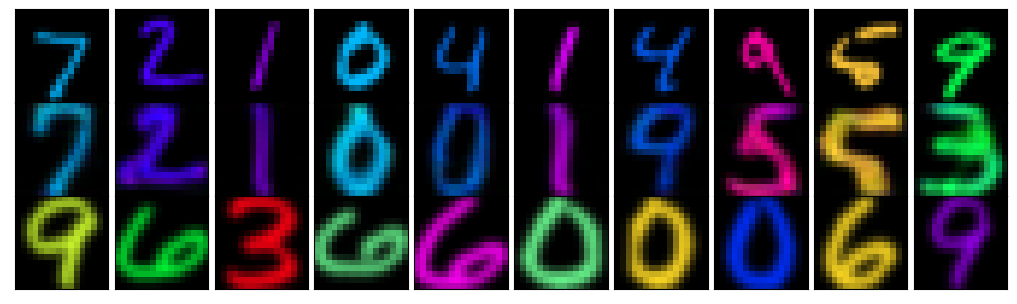

  3%|▎         | 3250/100001 [2:05:33<60:42:06,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


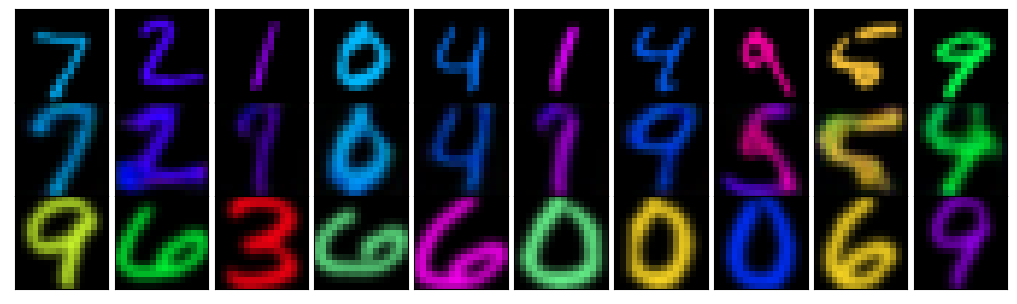

  3%|▎         | 3300/100001 [2:07:28<60:45:55,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


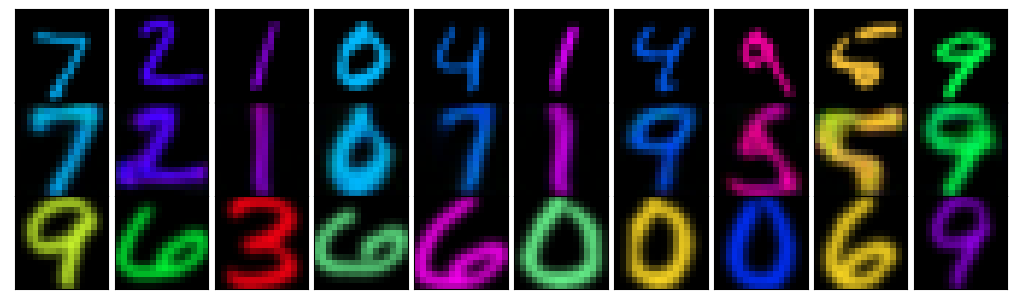

  3%|▎         | 3350/100001 [2:09:23<59:51:35,  2.23s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


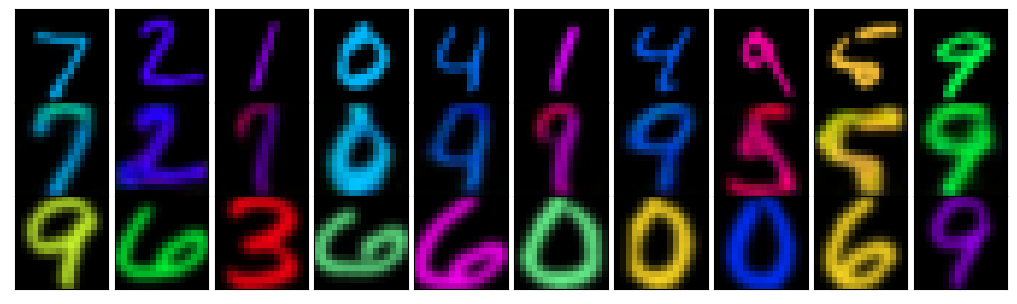

  3%|▎         | 3400/100001 [2:11:16<59:46:02,  2.23s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


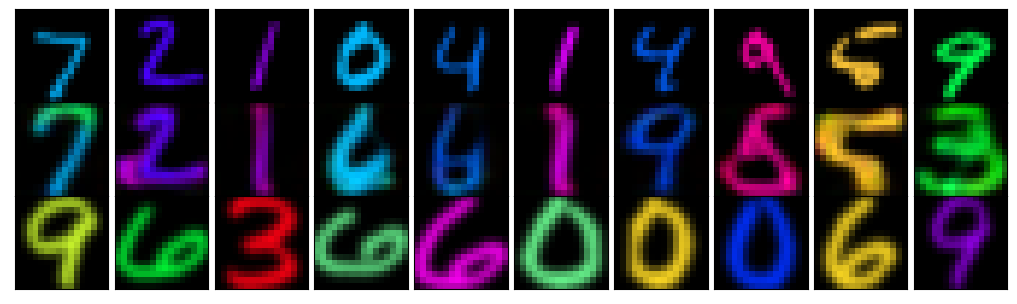

  3%|▎         | 3450/100001 [2:13:11<61:00:15,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


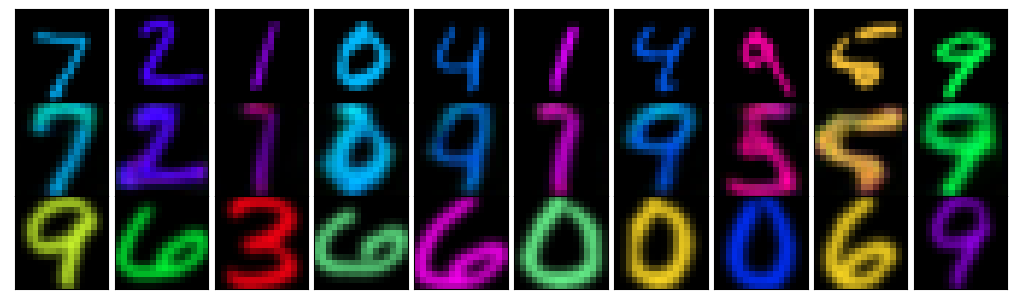

  3%|▎         | 3500/100001 [2:15:05<59:52:16,  2.23s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


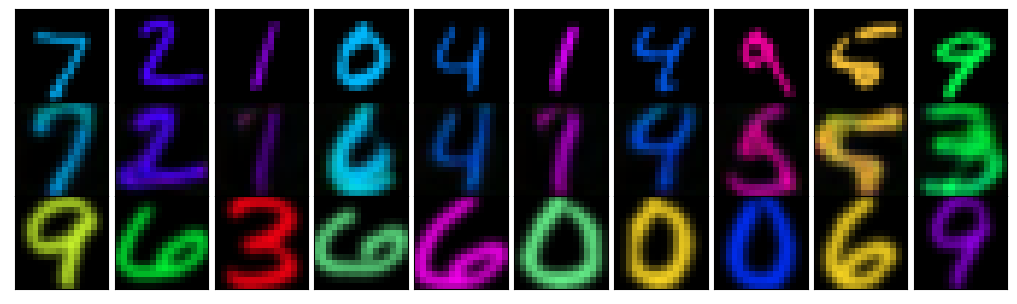

  4%|▎         | 3550/100001 [2:16:59<60:10:05,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


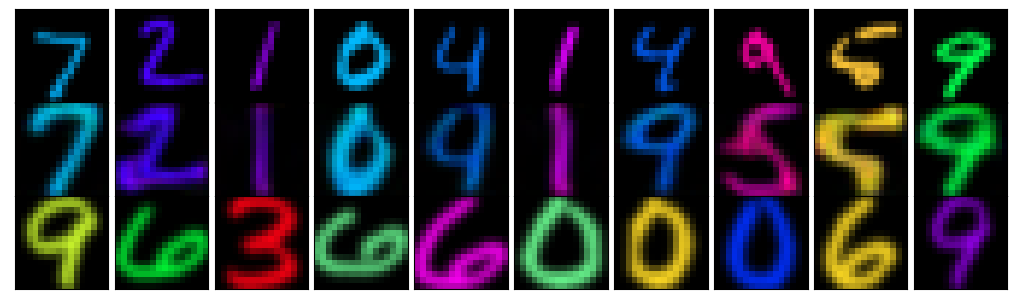

  4%|▎         | 3600/100001 [2:18:54<60:11:49,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


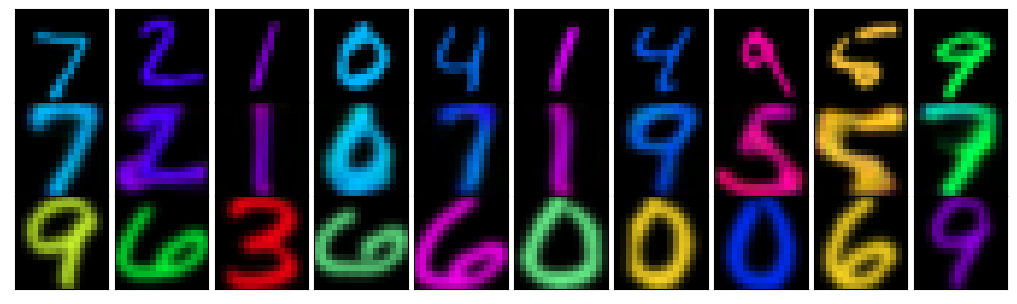

  4%|▎         | 3650/100001 [2:20:48<59:25:58,  2.22s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


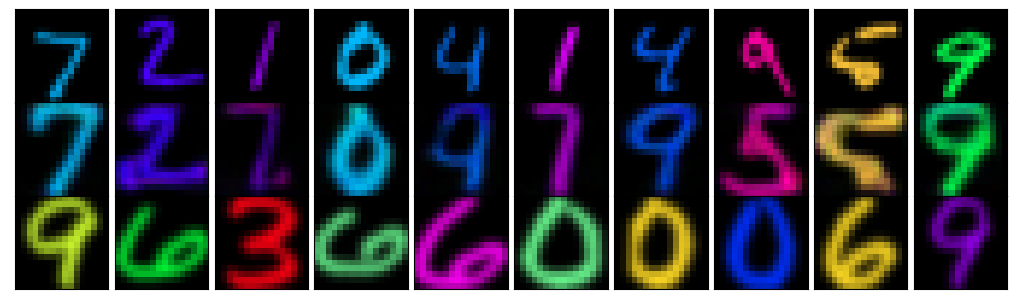

  4%|▎         | 3700/100001 [2:22:42<61:14:39,  2.29s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


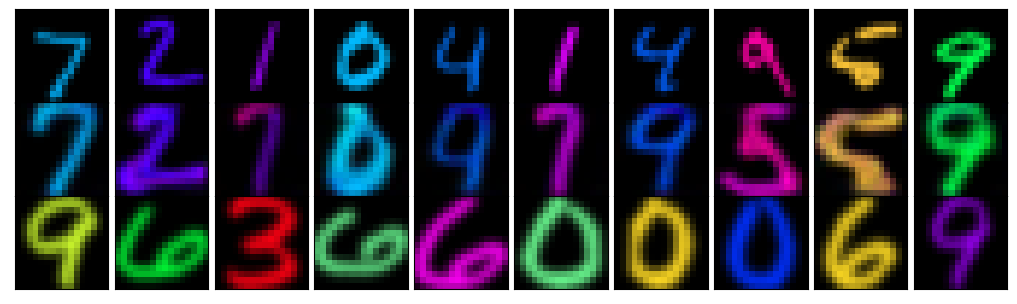

  4%|▎         | 3750/100001 [2:24:36<60:06:31,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


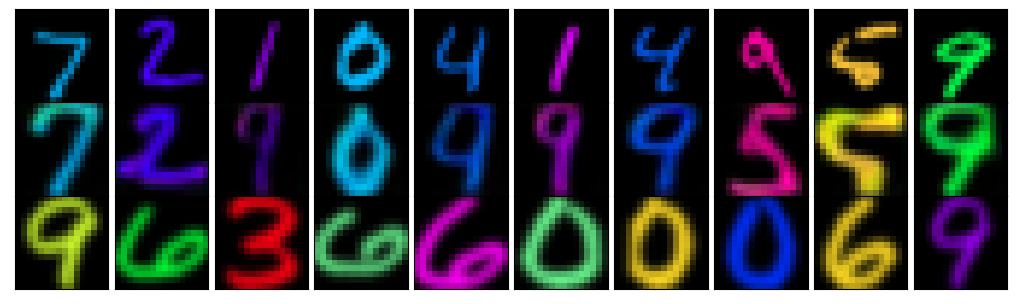

  4%|▍         | 3800/100001 [2:26:29<59:30:48,  2.23s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


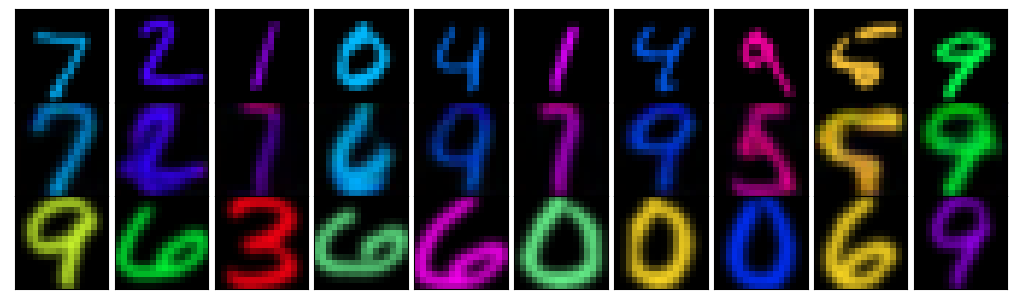

  4%|▍         | 3850/100001 [2:28:21<58:56:41,  2.21s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


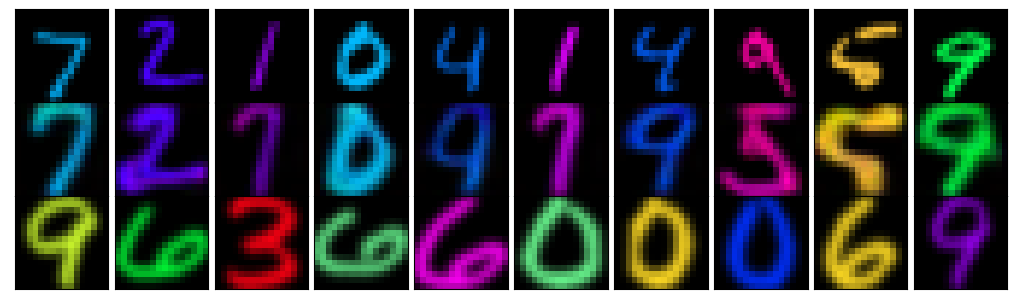

  4%|▍         | 3900/100001 [2:30:14<59:52:30,  2.24s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


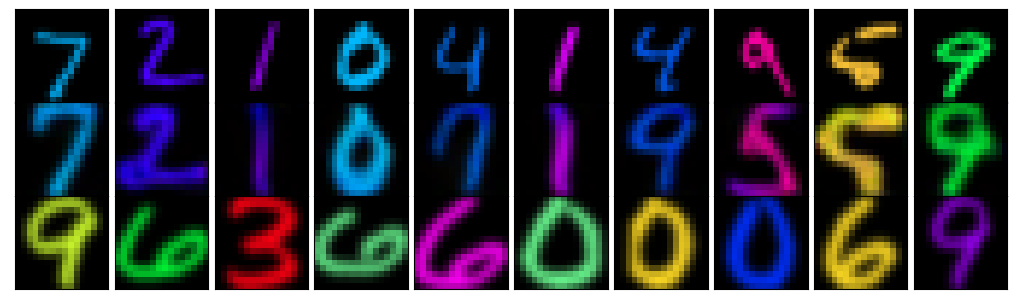

  4%|▍         | 3950/100001 [2:32:09<60:49:18,  2.28s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


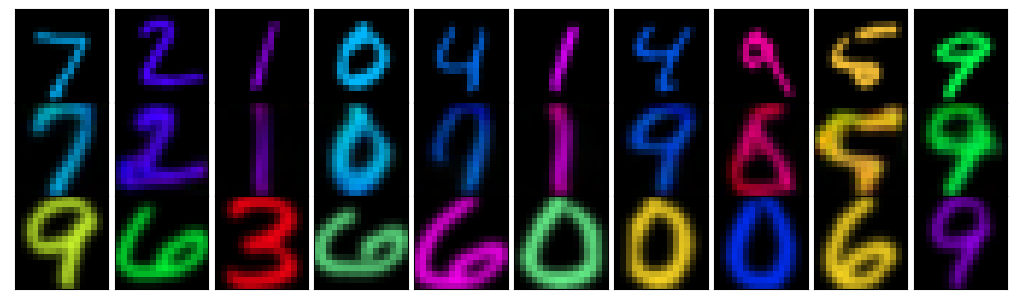

  4%|▍         | 4000/100001 [2:34:03<61:48:49,  2.32s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


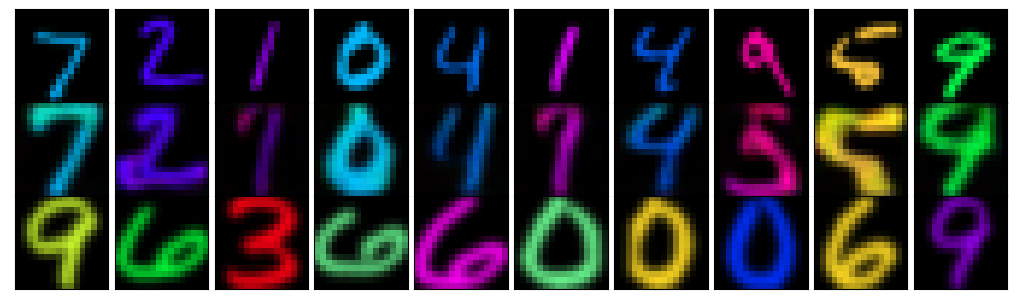

  4%|▍         | 4050/100001 [2:35:57<59:48:12,  2.24s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


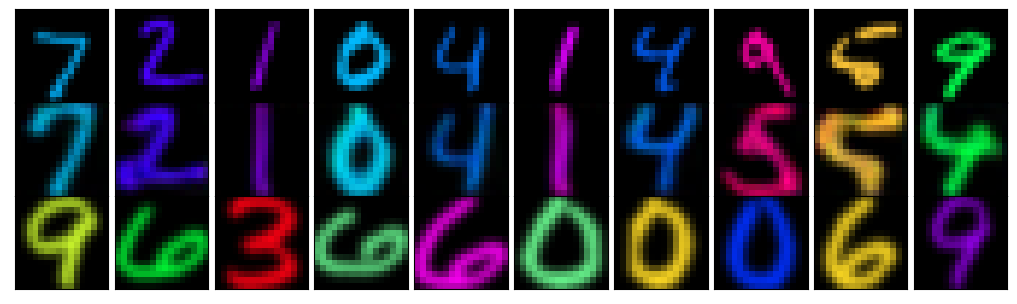

  4%|▍         | 4100/100001 [2:37:52<60:25:30,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


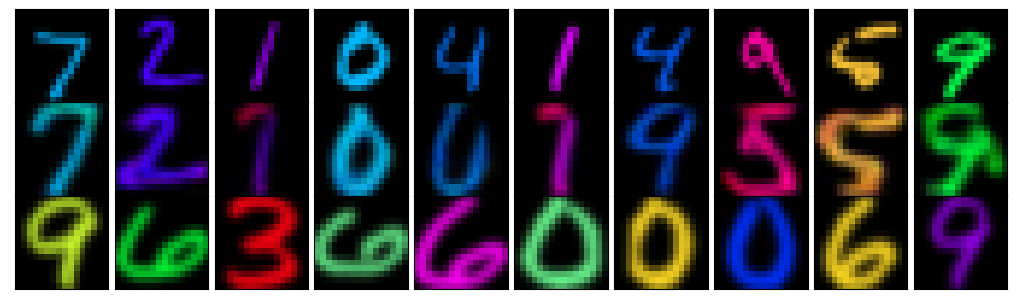

  4%|▍         | 4150/100001 [2:39:45<59:30:31,  2.24s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


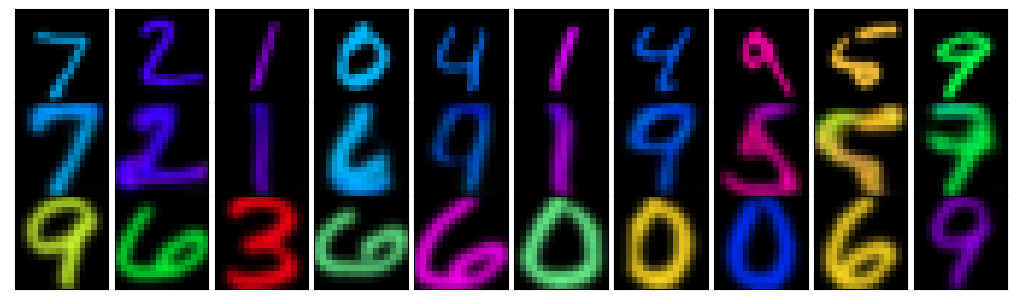

  4%|▍         | 4200/100001 [2:41:40<60:07:17,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


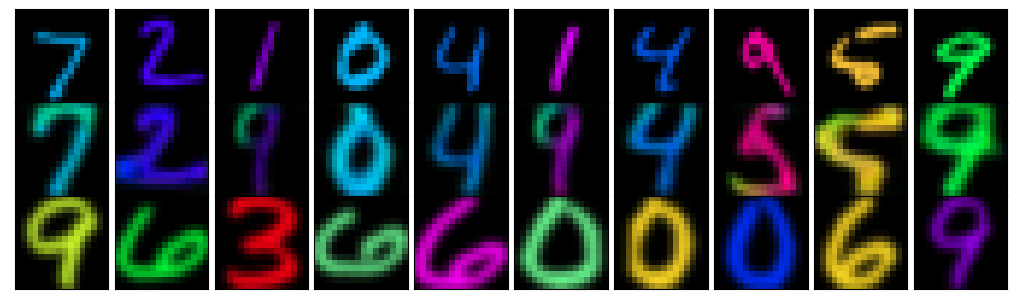

  4%|▍         | 4250/100001 [2:43:35<61:22:31,  2.31s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


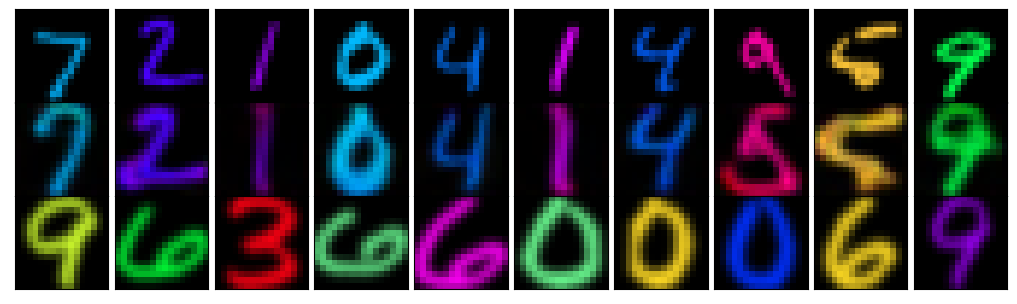

  4%|▍         | 4300/100001 [2:45:28<60:18:46,  2.27s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


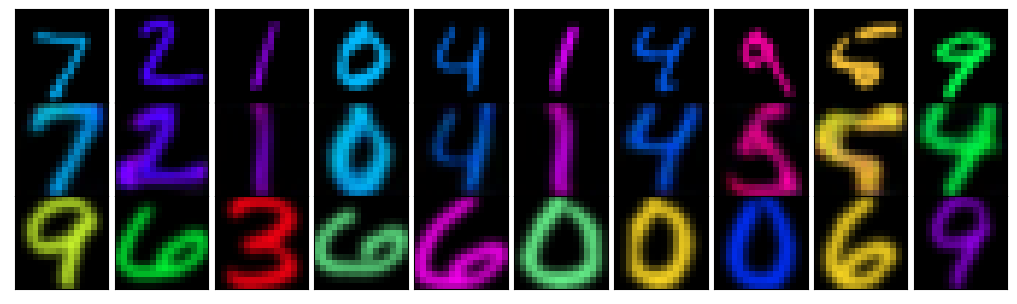

  4%|▍         | 4350/100001 [2:47:24<63:16:10,  2.38s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


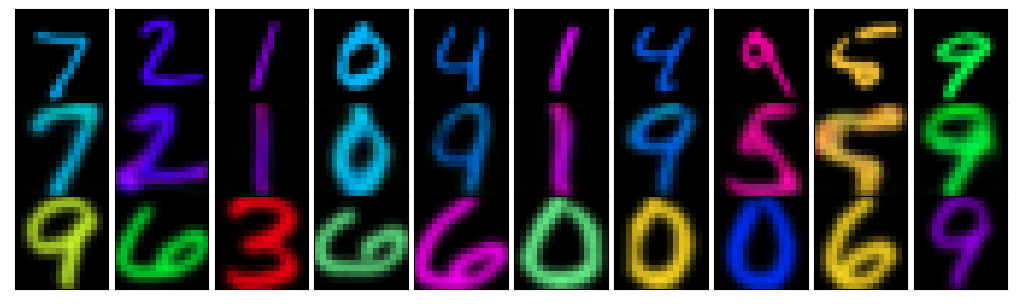

  4%|▍         | 4400/100001 [2:49:19<59:56:39,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


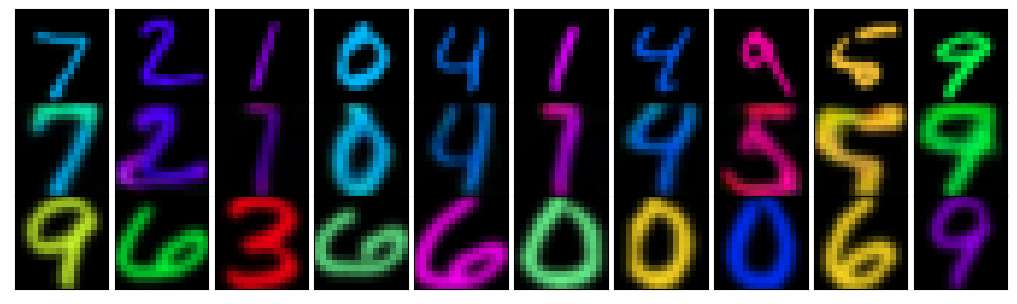

  4%|▍         | 4450/100001 [2:51:14<60:46:17,  2.29s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


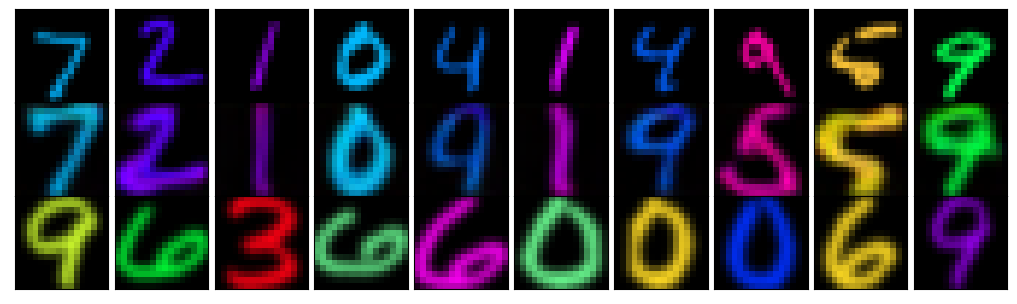

  4%|▍         | 4500/100001 [2:53:09<59:38:51,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


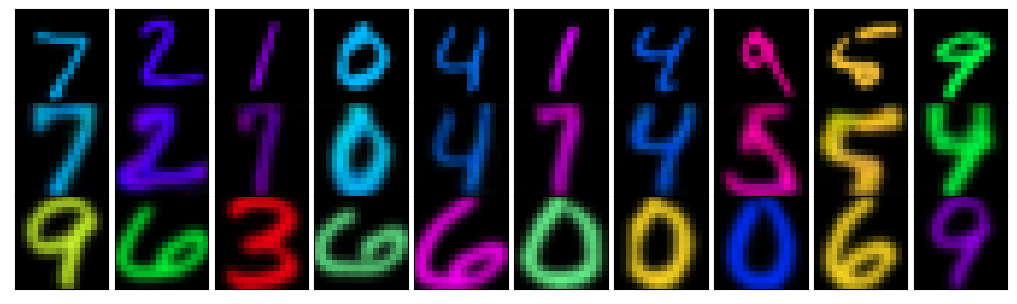

  5%|▍         | 4550/100001 [2:55:02<59:42:43,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


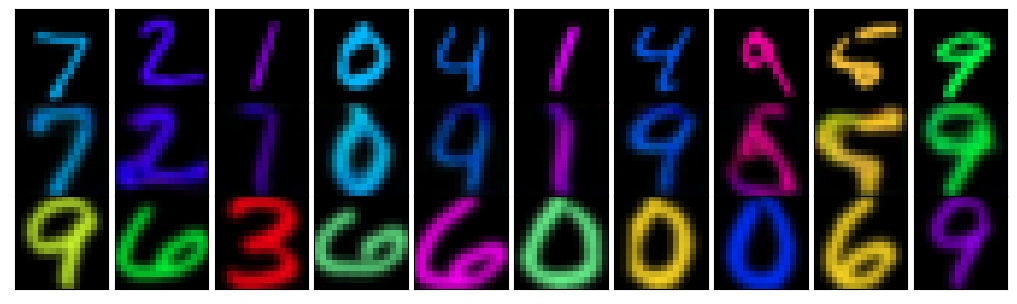

  5%|▍         | 4600/100001 [2:56:57<59:57:36,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


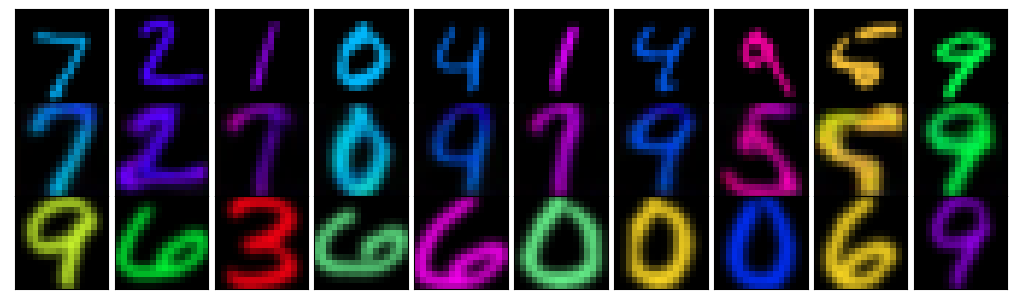

  5%|▍         | 4650/100001 [2:58:53<59:50:26,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


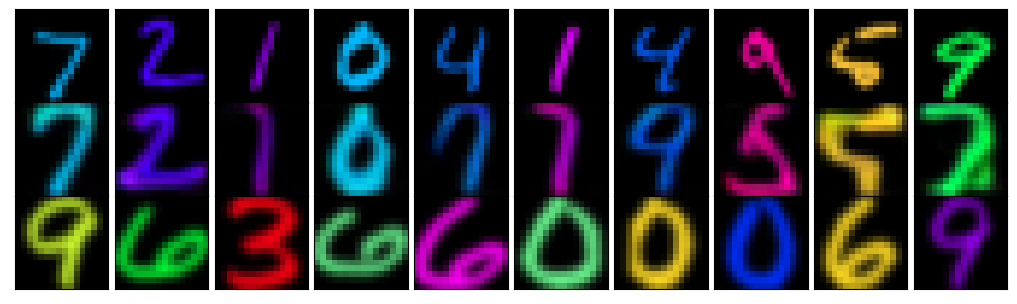

  5%|▍         | 4700/100001 [3:00:49<59:57:30,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


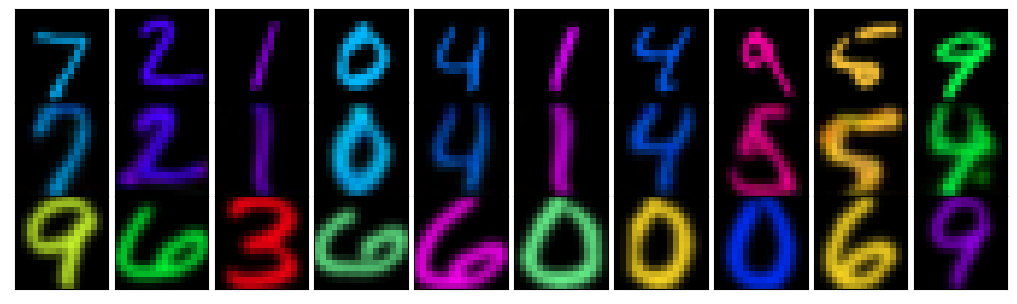

  5%|▍         | 4750/100001 [3:02:43<59:51:25,  2.26s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


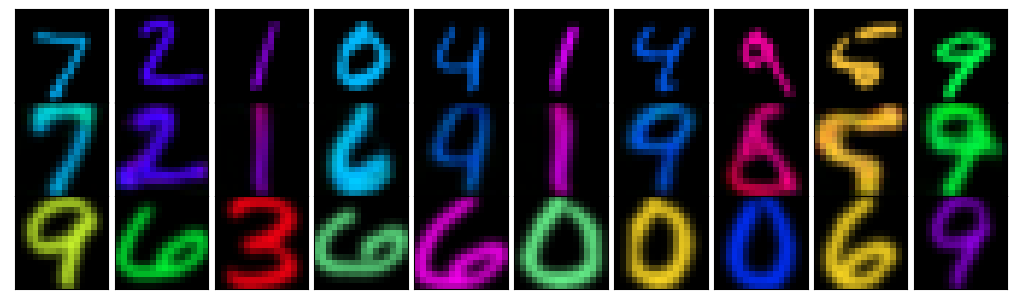

  5%|▍         | 4800/100001 [3:04:38<59:14:09,  2.24s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


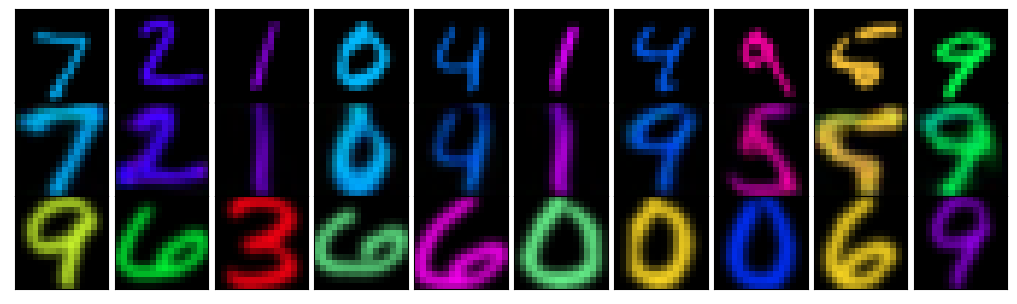

  5%|▍         | 4850/100001 [3:06:32<59:23:34,  2.25s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


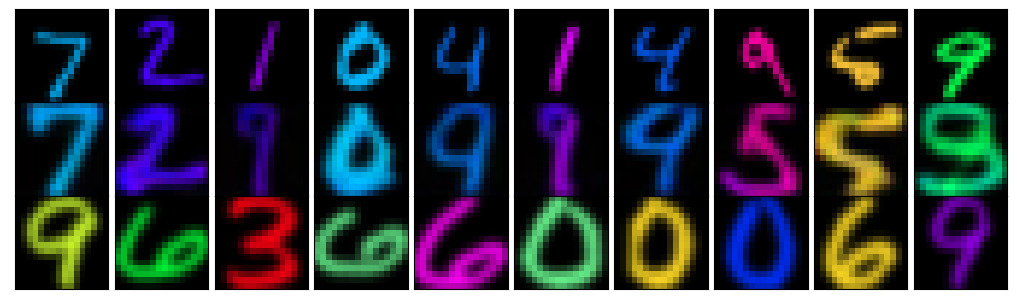

  5%|▍         | 4900/100001 [3:08:28<60:36:07,  2.29s/it]

Plotting
Mnist images X, mapped images T(X), unpaired USPS images Y


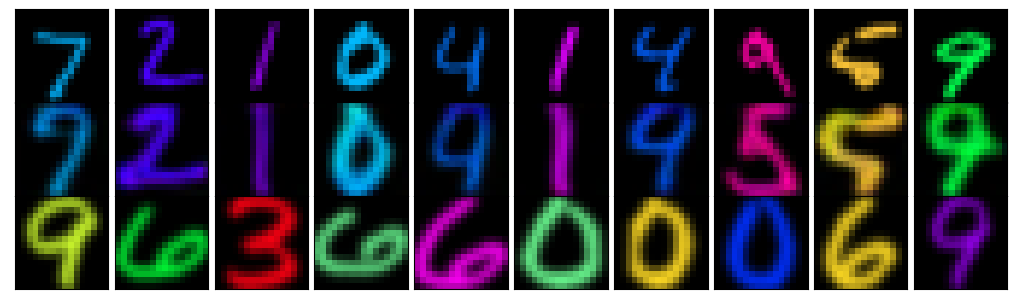

  5%|▍         | 4922/100001 [3:09:21<60:57:59,  2.31s/it]


KeyboardInterrupt: 

In [11]:
train_loop(T, f, sample_mnist, sample_usps, BATCH_SIZE=64)

In [ ]:
train_loop(T, f, sample_mnist, sample_usps, BATCH_SIZE=64)

# Main config

In [ ]:
# SOLVER_METHOD = 'dopri5' 
# SOLVER_METHOD = 'euler'
# SENSITIVITY = 'adjoint' # 'autograd'
# TOL = 1e-3

In [ ]:
# ADJOINT = False
# # SOLVER_METHOD = 'dopri5' #adaptive
# SOLVER_METHOD = 'adaptive_heun'
# SOLVER_METHOD = ode_solve
# TOL = 1e-3



# DEVICE_IDS = [0]

# # DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
# # DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'
# DATASET1, DATASET1_PATH = 'handbag', '../../data_chizhov/handbag_128.hdf5'
# DATASET2, DATASET2_PATH = 'shoes', '../../data_chizhov/shoes_128.hdf5'



# # DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# # DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

# T_ITERS = 10
# f_LR, T_LR = 1e-4, 1e-4
# IMG_SIZE = 64

# # BATCH_SIZE = 64
# BATCH_SIZE = 64

# PLOT_INTERVAL = 25
# COST = 'mse' # Mean Squared Error
# CPKT_INTERVAL = 2000
# MAX_STEPS = 100001
# SEED = 0x000000

# EXP_NAME = f'regularised2_{SOLVER_METHOD}_{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
# OUTPUT_PATH = 'checkpoints/{}/{}_{}_{}_{}/'.format(COST + '_regularised2', SOLVER_METHOD, DATASET1, DATASET2, IMG_SIZE)
# print(OUTPUT_PATH)
# torch.cuda.is_available()

In [ ]:
# config = dict(
#     ADJOINT=ADJOINT,
#     SOLVER_METHOD=SOLVER_METHOD,
#     DATASET1=DATASET1,
#     DATASET2=DATASET2,
#     T_ITERS=T_ITERS,
#     f_LR=f_LR, T_LR=T_LR,
#     BATCH_SIZE=BATCH_SIZE,
#     REGULARIZED = True
# )

# assert torch.cuda.is_available()
# torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
# torch.manual_seed(SEED); np.random.seed(SEED)

# if not os.path.exists(OUTPUT_PATH):
#     os.makedirs(OUTPUT_PATH)

In [ ]:
# # generator
# # datasets: http://efrosgans.eecs.berkeley.edu/iGAN/datasets/handbag_64.zip
# # datasets: http://efrosgans.eecs.berkeley.edu/iGAN/datasets/sketch_shoes_64.zip
# # datasets: http://efrosgans.eecs.berkeley.edu/iGAN/datasets/shoes_64.zip
# # implementation from  https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py
# from utils.unet import UNet_func
# import functools
# import functorch
# REGULARIZER = 0
# # Decorator with memory
# class nnModule_regulizer_decorator(nn.Module):
#     def __init__(self, odefunc):
#         super(nnModule_regulizer_decorator, self).__init__()
#         # REGULARISER must be initialised from outside
#         self.odefunc = odefunc
#         self.regularization_tensor = 0.
        
#     def __call__(self, t, x):
#         return self.forward(t, x)
       
#     def forward(self, t, x):
#         global REGULARIZER
#         value = self.odefunc(t, x)
#         f_t_x , second_derivative = functorch.jvp(func=self.odefunc,
#                                                   primals=(t, x),
#                                                   tangents = (torch.tensor(1.), value))
#         metric = torch.mean(torch.linalg.matrix_norm(second_derivative), dim=(0,1)) 
#         print(metric.shape)
#         # REGULARIZER = torch.max(REGULARIZER, torch.mean(torch.linalg.matrix_norm(second_derivative), dim = (0,1)))
#         # print(REGULARIZER)
#         return value
    
#     @property
#     def nfe(self):
#         return self.odefunc.nfe

#     @nfe.setter
#     def nfe(self, value):
#         self.odefunc.nfe = value



# # REGULARIZER = 0
# # def decorator(func):
# #     @functools.wraps(func)
# #     def wrapper_decorator(*args, **kwargs):
# #         # Do something before
# #         global REGULARIZER
# #         t, image_x = args
# #         value = func(*args, **kwargs)
# #         # Do something after
# #         # with torch.no_grad():
# #         print(value.shape)
# #         f_t_x , second_derivative = functorch.jvp(func=func,
# #                                           primals=(t, image_x),
# #                                           tangents = (torch.tensor(1.), value))
# #         REGULARIZER += torch.sum(torch.linalg.matrix_norm(second_derivative), dim=1)
# #         # print(REGULARIZER)
# #         return value
# #     return wrapper_decorator


# class ODEBlock(nn.Module):

#     def __init__(self, odefunc, method=SOLVER_METHOD, tol=TOL, regularised=True):
#         super(ODEBlock, self).__init__()
#         # REGULARISER must be initialised from outside
#         if regularised:
#             self.odefunc = nnModule_regulizer_decorator(odefunc)
#         else:
#             self.odefunc = odefunc
#         self.integration_time = torch.tensor([0, 1]).float()
#         self.tol = tol
#         self.method = method
#         self.regularised = regularised
        

#     def forward(self, x):
#         self.integration_time = self.integration_time.type_as(x)
        
#         if self.regularised:
#             global REGULARIZER
#             REGULARIZER = torch.tensor(0)
            
#         out = odeint(self.odefunc, x, self.integration_time,
#                      method=self.method, rtol=self.tol, atol=self.tol)
#         # gc.collect(); 
#         if self.regularised:
#             print('garbage collection', gc.collect(), torch.cuda.empty_cache())
#             print(REGULARIZER)
            
#         return out[1]
    
#     @property
#     def nfe(self):
#         return self.odefunc.nfe

#     @nfe.setter
#     def nfe(self, value):
#         self.odefunc.nfe = value





In [ ]:
# odeint?

In [ ]:
# # descriminator
# class ResNet_D(nn.Module):
#     "Discriminator ResNet architecture from https://github.com/harryliew/WGAN-QC"
#     def __init__(self, size=64, nc=3, nfilter=64, nfilter_max=512, res_ratio=0.1):
#         super().__init__()
#         s0 = self.s0 = 4
#         nf = self.nf = nfilter
#         nf_max = self.nf_max = nfilter_max
#         self.nc = nc

#         # Submodules
#         nlayers = int(np.log2(size / s0))
#         self.nf0 = min(nf_max, nf * 2**nlayers)

#         nf0 = min(nf, nf_max)
#         nf1 = min(nf * 2, nf_max)
#         blocks = [
#             ResNetBlock(nf0, nf0, bn=False, res_ratio=res_ratio),
#             ResNetBlock(nf0, nf1, bn=False, res_ratio=res_ratio)
#         ]

#         for i in range(1, nlayers+1):
#             nf0 = min(nf * 2**i, nf_max)
#             nf1 = min(nf * 2**(i+1), nf_max)
#             blocks += [
#                 nn.AvgPool2d(3, stride=2, padding=1),
#                 ResNetBlock(nf0, nf0, bn=False, res_ratio=res_ratio),
#                 ResNetBlock(nf0, nf1, bn=False, res_ratio=res_ratio),
#             ]

#         self.conv_img = nn.Conv2d(nc, 1*nf, 3, padding=1)
#         self.relu = nn.LeakyReLU(0.2, inplace=True)
#         self.resnet = nn.Sequential(*blocks)
#         self.fc = nn.Linear(self.nf0*s0*s0, 1)

#     def forward(self, x):
#         batch_size = x.size(0)

#         out = self.relu((self.conv_img(x)))
#         out = self.resnet(out)
#         out = out.view(batch_size, self.nf0*self.s0*self.s0)
#         out = self.fc(out)

#         return out


# class ResNetBlock(nn.Module):
#     def __init__(self, fin, fout, fhidden=None, bn=True, res_ratio=0.1):
#         super().__init__()
#         # Attributes
#         self.bn = bn
#         self.is_bias = not bn
#         self.learned_shortcut = (fin != fout)
#         self.fin = fin
#         self.fout = fout
#         if fhidden is None:
#             self.fhidden = min(fin, fout)
#         else:
#             self.fhidden = fhidden
#         self.res_ratio = res_ratio

#         # Submodules
#         self.conv_0 = nn.Conv2d(self.fin, self.fhidden, 3, stride=1, padding=1, bias=self.is_bias)
#         if self.bn:
#             self.bn2d_0 = nn.BatchNorm2d(self.fhidden)
#         self.conv_1 = nn.Conv2d(self.fhidden, self.fout, 3, stride=1, padding=1, bias=self.is_bias)
#         if self.bn:
#             self.bn2d_1 = nn.BatchNorm2d(self.fout)
#         if self.learned_shortcut:
#             self.conv_s = nn.Conv2d(self.fin, self.fout, 1, stride=1, padding=0, bias=False)
#             if self.bn:
#                 self.bn2d_s = nn.BatchNorm2d(self.fout)
#         self.relu = nn.LeakyReLU(0.2, inplace=True)

#     def forward(self, x):
#         x_s = self._shortcut(x)
#         dx = self.conv_0(x)
#         if self.bn:
#             dx = self.bn2d_0(dx)
#         dx = self.relu(dx)
#         dx = self.conv_1(dx)
#         if self.bn:
#             dx = self.bn2d_1(dx)
#         out = self.relu(x_s + self.res_ratio*dx)
#         return out

#     def _shortcut(self, x):
#         if self.learned_shortcut:
#             x_s = self.conv_s(x)
#             if self.bn:
#                 x_s = self.bn2d_s(x_s)
#         else:
#             x_s = x
#         return x_s


In [ ]:
# import os, sys
# sys.path.append("..")

# import matplotlib
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline 

# import numpy as np
# import torch
# import torch.nn as nn
# import torchvision
# import gc

# import torch.nn.functional as F

# from src_not.resnet2 import ResNet_D
# from src_not import distributions
# # from src.unet import UNet

# from src_not.tools import unfreeze, freeze
# from src_not.tools import weights_init_D
# from src_not.tools import load_dataset, get_pushed_loader_stats
# from src_not.fid_score import calculate_frechet_distance
# from src_not.plotters import plot_random_images, plot_images

# from copy import deepcopy
# import json

# from tqdm import tqdm_notebook as tqdm
# from IPython.display import clear_output

# import wandb # <--- online logging of the results
# from src_not.tools import fig2data, fig2img # for wandb

# # This needed to use dataloaders for some datasets
# from PIL import PngImagePlugin
# LARGE_ENOUGH_NUMBER = 100
# PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [ ]:
# ../NeuralOptimalTransport/stats/handbag_64_test.json

In [ ]:
# filename = '../NeuralOptimalTransport/stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
# with open(filename, 'r') as fp:
#     data_stats = json.load(fp)
#     mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
# del data_stats

In [ ]:
# len(sigma_data)

In [ ]:
# len(mu_data)

In [ ]:
# X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
# Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
# torch.cuda.empty_cache(); gc.collect()

init networks

In [ ]:
# from utils.unet import UNet_func
# ode_f = UNet_func(3, 3, base_factor=48).cuda()
# T = ODEBlock(ode_f, regularised=False).cuda()
# f = ResNet_D(IMG_SIZE, nc=3, nfilter=64, nfilter_max=512).cuda()
# f.apply(weights_init_D)

# # T = UNet(3, 3, base_factor=48).cuda()

# if len(DEVICE_IDS) > 1:
#     T = nn.DataParallel(T, device_ids=DEVICE_IDS)
#     f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
# print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
# print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

In [ ]:
# torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
# X_fixed = X_sampler.sample(10)
# Y_fixed = Y_sampler.sample(10)
# X_test_fixed = X_test_sampler.sample(10)
# Y_test_fixed = Y_test_sampler.sample(10)

In [ ]:
# fig, axes = plot_images(X_fixed, Y_fixed, T)
# fig, axes = plot_random_images(X_sampler, Y_sampler, T)
# fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
# fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

In [ ]:
# wandb.init(name=EXP_NAME, project='ode_strong_not', config=config)


In [ ]:
# T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
# f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

In [ ]:
# torch.tensor([[11], [22], [33], [44]])[torch.randperm(4)]

In [ ]:
# t_eval = torch.tensor([1, 2, 3, 4, 5, 6])
# BATCH_SIZE = 10
# rand_ind = torch.randint(len(t_eval), (BATCH_SIZE,))
# print(rand_ind)
# chosen_time_per_elem = t_eval[rand_ind]
# print(chosen_time_per_elem)



In [ ]:
# trajectories[rand_ind, range(BATCH_SIZE), :, :].shape

In [ ]:
# traj_buf = []
# for j, i in zip(rand_ind, range(BATCH_SIZE)):
#     print(trajectories[j, i, :, :].shape)
#     traj_buf.append(trajectories[j, i, :, :])
# torch.sum(abs(torch.stack(traj_buf) - trajectories[rand_ind, range(BATCH_SIZE), :, :]))

In [ ]:
# sample = torch.randint(6, (10,))
# trajectories = torch.rand(6, 10, 3, 4, 4)
# # trajectories[torch.stack((sample, torch.arange(0,10))).T]
# torch.stack((sample, torch.arange(0,10))).T

In [ ]:
# def train_loop(T, f):
#     for step in tqdm(range(MAX_STEPS)):
#     # T optimization
#     unfreeze(T); freeze(f)
#     avg_gen_opt_step_time = 0
#     avg_num_func_eval_per_opt_step = 0
#     for t_iter in range(T_ITERS):
       
#         generator_opt_step_time = time.time()
#         T_opt.zero_grad()
#         X = X_sampler.sample(BATCH_SIZE)
        
#         t_eval, trajectories = T(X, return_trajectory=True)
#         T_X = trajectories[-1]
        
#         if regularized:
#             # sampling random time for everi image in batch
#             rand_ind = torch.randint(len(t_eval), (BATCH_SIZE,))
#             random_t = t_eval[rand_ind]
#             random_X_batch = trajectories[rand_ind, range(BATCH_SIZE), :, :]

#             # T(X, t) -> t - ожидаемые моменты времени (можно ли разные в батче?) odeint -> (либо интерполировать, либо останавливаться в дополнительных точках)
#             # T_X = T(X)
#             # array все точки во всех временах t?
#             # подставить нужный x(t) в регуояризатор
#             # альтернативно, заранее задать 10 точек траектории + финальную, для каждого элемента бача сэмплить одну из этих точек для регуляризации 
#             # regularization 
#             # t = torch.rand(size=(1,)).to(X)
#             #TODO sample different time for elem in batch
#             # regularizing
#             random_t = random_t.detach()
#             random_X_batch = random_X_batch.detach()
#             value = T.odefunc(random_t, random_X_batch)
#             _ , second_derivative = functorch.jvp(func=T.odefunc,
#                                                   primals=(random_t, random_X_batch),
#                                                   tangents = (torch.tensor([1.]).to(X), value))
#             reg_loss = second_derivative.square().mean() 
#         else:
#             reg_loss = 0
            
#         # total_loss
#         if COST == 'mse':
#             T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean() + reg_loss
#         else:
#             raise Exception('Unknown COST')
            
#         with torch.no_grad():
#             num_func_eval = T.nfe
#         T_loss.backward(); T_opt.step()
#         with torch.no_grad():
#             num_func_eval_per_opt_step = T.nfe - num_func_eval
        
#         generator_opt_step_time = time.time() - generator_opt_step_time
#         avg_gen_opt_step_time += generator_opt_step_time
#         avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step
        
#     avg_gen_opt_step_time /= T_ITERS 
#     avg_num_func_eval_per_opt_step /= T_ITERS
#     # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

#     # f optimization
#     freeze(T); unfreeze(f)
#     discriminator_opt_step_time = time.time()
#     X = X_sampler.sample(BATCH_SIZE)
#     with torch.no_grad():
#         T_X = T(X)
#     Y = Y_sampler.sample(BATCH_SIZE)
#     f_opt.zero_grad()
#     f_loss = f(T_X).mean() - f(Y).mean()
#     f_loss.backward(); f_opt.step();
#     discriminator_opt_step_time = time.time() - discriminator_opt_step_time
#     wandb.log({'f_loss' : f_loss.item(),
#                'T_loss' : T_loss.item(),
#                'reg_loss' : reg_loss.item(),
#               'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
#               'avg_gen_opt_step_time' : avg_gen_opt_step_time,
#               'discriminator_opt_step_time' : discriminator_opt_step_time
#               }, step=step) 
            
#     if step % PLOT_INTERVAL == 0:
#         print('Plotting')
#         clear_output(wait=True)
        
#         fig, axes = plot_images(X_fixed, Y_fixed, T)
#         wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
        
#         fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
#         wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
        
#         fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
#         wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
        
#         fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
#         wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
    
#     if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
#         freeze(T); 
        
#         print('Computing FID')
#         mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
#         fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
#         wandb.log({f'FID (Test)' : fid}, step=step)
#         # del mu, sigma
        
#         torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
# #         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
# #         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
# #         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt')

    

In [ ]:

# # https://pytorch.org/functorch/stable/batch_norm.html?highlight=batchnorm
# for step in tqdm(range(MAX_STEPS)):
#     # T optimization
#     unfreeze(T); freeze(f)
#     avg_gen_opt_step_time = 0
#     avg_num_func_eval_per_opt_step = 0
#     for t_iter in range(T_ITERS):
#         REGULARIZER = 0
#         generator_opt_step_time = time.time()
#         T_opt.zero_grad()
#         X = X_sampler.sample(BATCH_SIZE)
        
#         #TODO sample t (batch, ), 
#         # T(X, t) -> t - ожидаемые моменты времени (можно ли разные в батче?) odeint -> (либо интерполировать, либо останавливаться в дополнительных точках)
#         T_X = T(X)
#         # array все точки во всех временах t?
#         # подставить нужный x(t) в регуояризатор
#         # альтернативно, заранее задать 10 точек траектории + финальную, для каждого элемента бача сэмплить одну из этих точек для регуляризации 
#         # regularization 
#         t = torch.rand(size=(1,)).to(X)
#         #TODO sample different time for elem in batch
#         value = T.odefunc(t, X)
        
#         _ , second_derivative = functorch.jvp(func=T.odefunc,
#                                               primals=(t, X),
#                                               tangents = (torch.tensor([1.]).to(X), value))
#         reg_loss = torch.mean(torch.linalg.matrix_norm(second_derivative), dim=(0,1)) 
#         # total_loss
#         if COST == 'mse':
#             T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean() + reg_loss
#             T_loss_reg = T_loss + reg_loss
#         else:
#             raise Exception('Unknown COST')
            
#         with torch.no_grad():
#             num_func_eval = T.nfe
#         T_loss.backward(); T_opt.step()
#         with torch.no_grad():
#             num_func_eval_per_opt_step = T.nfe - num_func_eval
        
#         generator_opt_step_time = time.time() - generator_opt_step_time
#         avg_gen_opt_step_time += generator_opt_step_time
#         avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step
        
#     avg_gen_opt_step_time /= T_ITERS 
#     avg_num_func_eval_per_opt_step /= T_ITERS
#     # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

#     # f optimization
#     freeze(T); unfreeze(f)
#     discriminator_opt_step_time = time.time()
#     X = X_sampler.sample(BATCH_SIZE)
#     with torch.no_grad():
#         T_X = T(X)
#     Y = Y_sampler.sample(BATCH_SIZE)
#     f_opt.zero_grad()
#     f_loss = f(T_X).mean() - f(Y).mean()
#     f_loss.backward(); f_opt.step();
#     discriminator_opt_step_time = time.time() - discriminator_opt_step_time
#     wandb.log({'f_loss' : f_loss.item(),
#                'T_loss' : T_loss.item(),
#                'reg_loss' : reg_loss.item(),
#               'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
#               'avg_gen_opt_step_time' : avg_gen_opt_step_time,
#               'discriminator_opt_step_time' : discriminator_opt_step_time
#               }, step=step) 
#     # del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
#     if step % PLOT_INTERVAL == 0:
#         print('Plotting')
#         clear_output(wait=True)
        
#         fig, axes = plot_images(X_fixed, Y_fixed, T)
#         wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
        
#         fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
#         wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
        
#         fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
#         wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
        
#         fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
#         wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
#         plt.show(fig); plt.close(fig) 
    
#     if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
#         freeze(T); 
        
#         print('Computing FID')
#         mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
#         fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
#         wandb.log({f'FID (Test)' : fid}, step=step)
#         # del mu, sigma
        
#         torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
# #         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
# #         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
# #         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
#     # gc.collect(); torch.cuda.empty_cache()

In [ ]:
# import torch
# import gc
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size())
#     except:
#         pass